# Environment Setup

## Package Installation

In [1]:
# %pip install pandas matplotlib numpy seaborn scikit-learn xgboost patsy statsmodels
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install seaborn
# %pip install pmdarima
# %pip install tqdm

## Imports and GPU Configuration

In [2]:
# Cell 1 - Environment Setup and Imports
import warnings
import os
warnings.filterwarnings('ignore')

# Essential libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import platform
from scipy import stats

# Time series specific
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# ML/DL libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting settings - using a more reliable approach
plt.style.use('default')  # Reset to default style
sns.set_style("whitegrid")  # Apply seaborn styling
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

def print_gpu_info():
    """
    Print detailed information about GPU configuration
    """
    print("System Information:")
    print(f"Python version: {sys.version}")
    print(f"Platform: {platform.platform()}")
    print(f"PyTorch version: {torch.__version__}")
    
    print("\nGPU Information:")
    if torch.cuda.is_available():
        print(f"GPU Available: Yes")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        print(f"Current GPU: {torch.cuda.current_device()}")
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
        
        # Test GPU with a simple operation
        print("\nTesting GPU...")
        x = torch.randn(1000, 1000).cuda()
        y = torch.matmul(x, x.t())
        print("GPU test successful!")
    else:
        print("No GPU available. Using CPU.")

print_gpu_info()

Using device: cuda
System Information:
Python version: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
PyTorch version: 2.5.1+cu121

GPU Information:
GPU Available: Yes
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 4070 Ti
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB

Testing GPU...
GPU test successful!


# Data Loading and Preprocessing

- Data Import
- Initial Data Quality Checks
- Missing Values Analysis
- DateTime Index Setup

In [3]:
# Cell 2 - Data Loading and Basic Checks
def load_data(filepath):
    """
    Load and preprocess the time series data
    Parameters:
    filepath (str): Path to the CSV file
    Returns:
    pd.DataFrame: Preprocessed DataFrame with DateTime index
    """
    # Read the CSV file
    df = pd.read_csv(filepath)

    # Try to detect the datetime format automatically
    try:
        df['DateTime'] = pd.to_datetime(df['DateTime'], format='mixed')
    except ValueError as e:
        print(f"Warning: {e}")
        print("Attempting alternative datetime parsing...")
        try:
            df['DateTime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
        except Exception as e:
            print(f"Error in datetime parsing: {e}")
            raise

    # Set DateTime as index
    df.set_index('DateTime', inplace=True)

    # Sort index to ensure chronological order
    df.sort_index(inplace=True)

    # Display basic information
    print("\nDataset Info:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())
    print("\nLast few rows:")
    print(df.tail())
    print("\nBasic statistics:")
    print(df.describe())

    return df

# Load the data
try:
    df = load_data('ts2024.csv')
except Exception as e:
    print(f"Error loading data: {e}")
    raise


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2015-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    17544 non-null  object 
 1   Hour    17544 non-null  int64  
 2   X       16800 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 548.2+ KB
None

First few rows:
                           Date  Hour       X
DateTime                                     
2015-01-01 00:00:00  2015-01-01     0  0.0146
2015-01-01 01:00:00  2015-01-01     1  0.0148
2015-01-01 02:00:00  2015-01-01     2  0.0101
2015-01-01 03:00:00  2015-01-01     3  0.0060
2015-01-01 04:00:00  2015-01-01     4  0.0055

Last few rows:
                           Date  Hour   X
DateTime                                 
2016-12-31 19:00:00  2016-12-31    19 NaN
2016-12-31 20:00:00  2016-12-31    20 NaN
2016-12-31 21:00:00  2016-12-31    21 NaN
2016-12-31 22:00:00  20

In [4]:
# Cell 3 - Data Quality Analysis and Cleaning
def analyze_data_quality(df):
    """
    Perform comprehensive data quality analysis
    """
    print("=== Data Quality Analysis ===")

    # Basic dataset properties
    print("\n1. Dataset Properties:")
    print(f"Time range: {df.index.min()} to {df.index.max()}")
    print(f"Total number of records: {len(df)}")
    print(f"Sampling frequency: {df.index.freq if df.index.freq else 'Inferred hourly'}")

    # Check for duplicates
    duplicates = df.index.duplicated(keep=False)
    if duplicates.any():
        n_duplicates = duplicates.sum()
        print(f"\nWarning: Found {n_duplicates} duplicate timestamps!")
        print("\nExample of duplicates:")
        print(df[duplicates].sort_index().head())

    # Check for time series continuity
    expected_periods = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_periods = set(expected_periods) - set(df.index)

    print("\n2. Time Series Continuity:")
    print(f"Number of missing timestamps: {len(missing_periods)}")
    if missing_periods:
        print("Sample of missing timestamps:")
        print(sorted(list(missing_periods))[:5])

    # Value distribution analysis
    print("\n3. Value Distribution (X):")
    print(df['X'].describe())

    # Outlier detection
    Q1 = df['X'].quantile(0.25)
    Q3 = df['X'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['X'] < (Q1 - 1.5 * IQR)) | (df['X'] > (Q3 + 1.5 * IQR))]

    print("\n4. Outlier Analysis:")
    print(f"Number of potential outliers: {len(outliers)}")
    if len(outliers) > 0:
        print("Sample of outliers:")
        print(outliers.head())

    # Missing data patterns
    print("\n5. Missing Data Patterns:")
    missing_by_month = df['X'].isna().groupby(df.index.month).sum()
    print("Missing values by month:")
    print(missing_by_month)

    return missing_periods, outliers, duplicates

def clean_data(df, duplicates):
    """
    Clean the data by:
    1. Handling duplicates by taking their mean
    2. Filling ONLY the two specific missing timestamps in historical data
    3. Keeping the last 744 values as missing for forecasting
    """
    print("=== Data Cleaning ===")
    
    df_cleaned = df.copy()
    
    # Step 1: Handle duplicates by taking the mean of X values for same timestamps
    if duplicates.any():
        print("\nHandling duplicates by taking the mean value for each timestamp...")
        df_cleaned = df_cleaned.groupby(level=0).agg({
            'Date': 'first',  # Keep first date string
            'Hour': 'first',  # Keep first hour
            'X': 'mean'      # Take mean of X values
        })
        print(f"After handling duplicates: {len(df_cleaned)} rows")
    
    # Step 2: Handle ONLY the two specific missing timestamps
    specific_missing = pd.to_datetime(['2015-03-29 02:00:00', '2016-03-27 02:00:00'])
    
    for timestamp in specific_missing:
        if timestamp in df_cleaned.index:
            continue
            
        # Get the same hour from the day before and after
        prev_day = df_cleaned.loc[timestamp - pd.Timedelta(days=1):timestamp - pd.Timedelta(days=1), 'X'].iloc[0]
        next_day = df_cleaned.loc[timestamp + pd.Timedelta(days=1):timestamp + pd.Timedelta(days=1), 'X'].iloc[0]
        
        # Create new row with interpolated value
        df_cleaned.loc[timestamp] = {
            'Date': timestamp.date(),
            'Hour': timestamp.hour,
            'X': (prev_day + next_day) / 2
        }
    
    # Sort index to ensure chronological order
    df_cleaned.sort_index(inplace=True)
    
    # Verify the cleaning worked correctly
    print("\nVerification after cleaning:")
    n_missing = df_cleaned['X'].isna().sum()
    print(f"Total missing values (should be 744): {n_missing}")
    
    if n_missing != 744:
        raise ValueError(f"ERROR: Expected 744 missing values, but found {n_missing}")
        
    return df_cleaned

# Analyze and clean data
missing_periods, outliers, duplicates = analyze_data_quality(df)

=== Data Quality Analysis ===

1. Dataset Properties:
Time range: 2015-01-01 00:00:00 to 2016-12-31 23:00:00
Total number of records: 17544
Sampling frequency: Inferred hourly


Example of duplicates:
                           Date  Hour       X
DateTime                                     
2015-10-25 02:00:00  2015-10-25     2  0.0060
2015-10-25 02:00:00  2015-10-25     2  0.0053
2016-10-30 02:00:00  2016-10-30     2  0.0072
2016-10-30 02:00:00  2016-10-30     2  0.0062

2. Time Series Continuity:
Number of missing timestamps: 2
Sample of missing timestamps:
[Timestamp('2015-03-29 02:00:00'), Timestamp('2016-03-27 02:00:00')]

3. Value Distribution (X):
count    16800.000000
mean         0.046320
std          0.048945
min          0.000000
25%          0.018200
50%          0.036800
75%          0.053800
max          0.450000
Name: X, dtype: float64

4. Outlier Analysis:
Number of potential outliers: 1010
Sample of outliers:
                           Date  Hour       X
DateTime     

In [5]:
df = clean_data(df, duplicates)

=== Data Cleaning ===

Handling duplicates by taking the mean value for each timestamp...
After handling duplicates: 17542 rows

Verification after cleaning:
Total missing values (should be 744): 744


In [6]:
# Cell 4 - Data Preprocessing and Feature Engineering
def preprocess_data(df):
    """
    Preprocess the time series data and engineer features
    """
    print("=== Data Preprocessing and Feature Engineering ===")

    # Create a copy to avoid modifying original data
    df_processed = df.copy()

    # Add time-based features
    df_processed['hour'] = df_processed.index.hour
    df_processed['day_of_week'] = df_processed.index.dayofweek
    df_processed['month'] = df_processed.index.month
    df_processed['is_weekend'] = df_processed.index.dayofweek.isin([5, 6]).astype(int)

    # Calculate rolling statistics (excluding the missing period)
    non_missing = df_processed[df_processed['X'].notna()]
    df_processed['rolling_mean_24h'] = non_missing['X'].rolling(window=24, min_periods=1).mean()
    df_processed['rolling_std_24h'] = non_missing['X'].rolling(window=24, min_periods=1).std()

    # Print summary of changes
    print("\nAdded features:")
    for col in df_processed.columns:
        print(f"- {col}")

    print("\nProcessing Summary:")
    print(f"Original shape: {df.shape}")
    print(f"Processed shape: {df_processed.shape}")

    return df_processed

# Preprocess the data
df_processed = preprocess_data(df)

=== Data Preprocessing and Feature Engineering ===

Added features:
- Date
- Hour
- X
- hour
- day_of_week
- month
- is_weekend
- rolling_mean_24h
- rolling_std_24h

Processing Summary:
Original shape: (17544, 3)
Processed shape: (17544, 9)


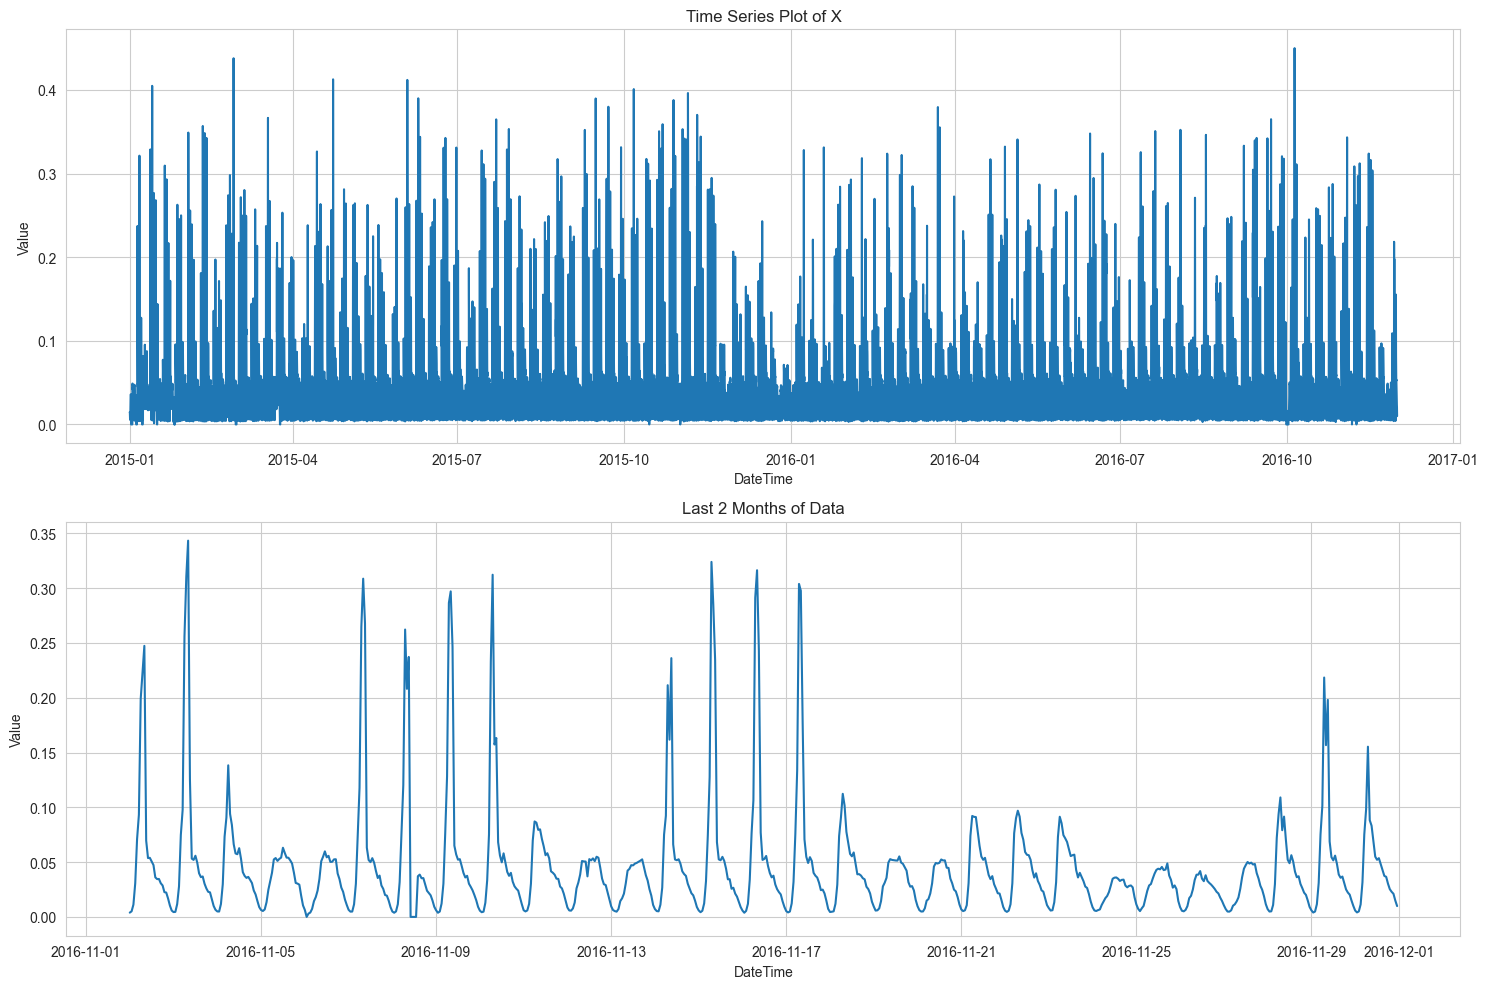

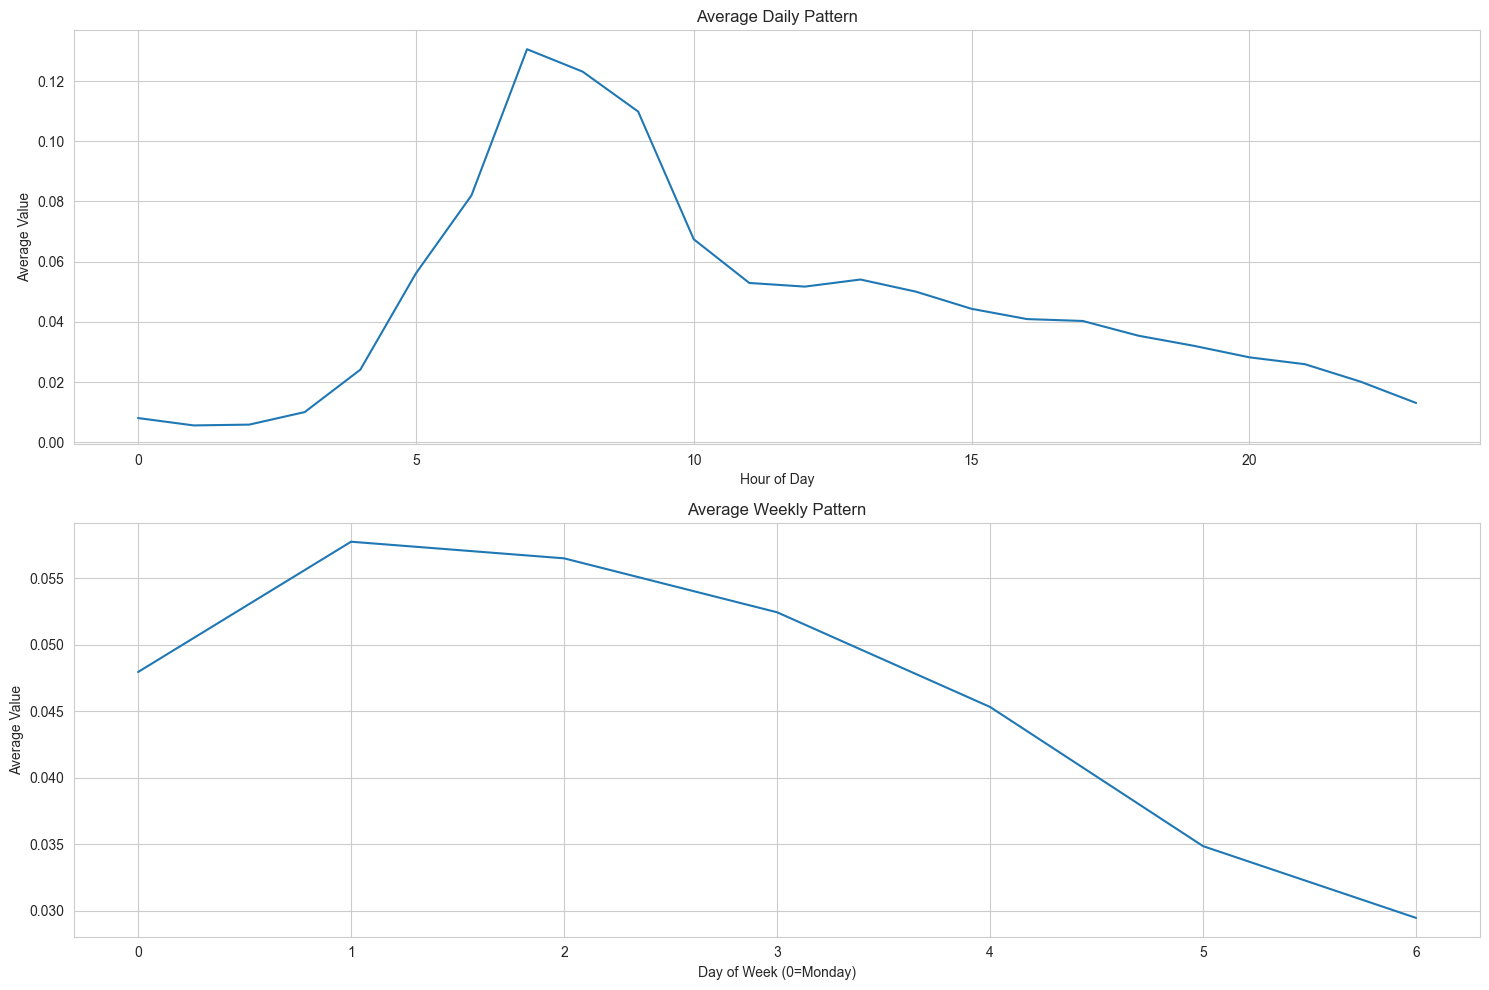

In [7]:
# Cell 5 - Initial Visualizations
def plot_time_series(df):
    """
    Create initial visualizations of the time series data
    """
    # Plot the entire time series
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df['X'])
    plt.title('Time Series Plot of X')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.grid(True)

    # Plot the last 2 months of data
    last_2_months = df.last('60D')
    plt.subplot(2, 1, 2)
    plt.plot(last_2_months.index, last_2_months['X'])
    plt.title('Last 2 Months of Data')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_patterns(df):
    """
    Plot daily and weekly patterns
    """
    plt.figure(figsize=(15, 10))

    # Daily pattern
    plt.subplot(2, 1, 1)
    daily_pattern = df.groupby(df.index.hour)['X'].mean()
    plt.plot(daily_pattern.index, daily_pattern.values)
    plt.title('Average Daily Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Value')
    plt.grid(True)

    # Weekly pattern
    plt.subplot(2, 1, 2)
    weekly_pattern = df.groupby(df.index.dayofweek)['X'].mean()
    plt.plot(weekly_pattern.index, weekly_pattern.values)
    plt.title('Average Weekly Pattern')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Average Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Create visualizations
plot_time_series(df)
plot_patterns(df)

=== Stationarity Analysis ===
ADF Statistic: -15.709489956924452
p-value: 1.3650064331681149e-28
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


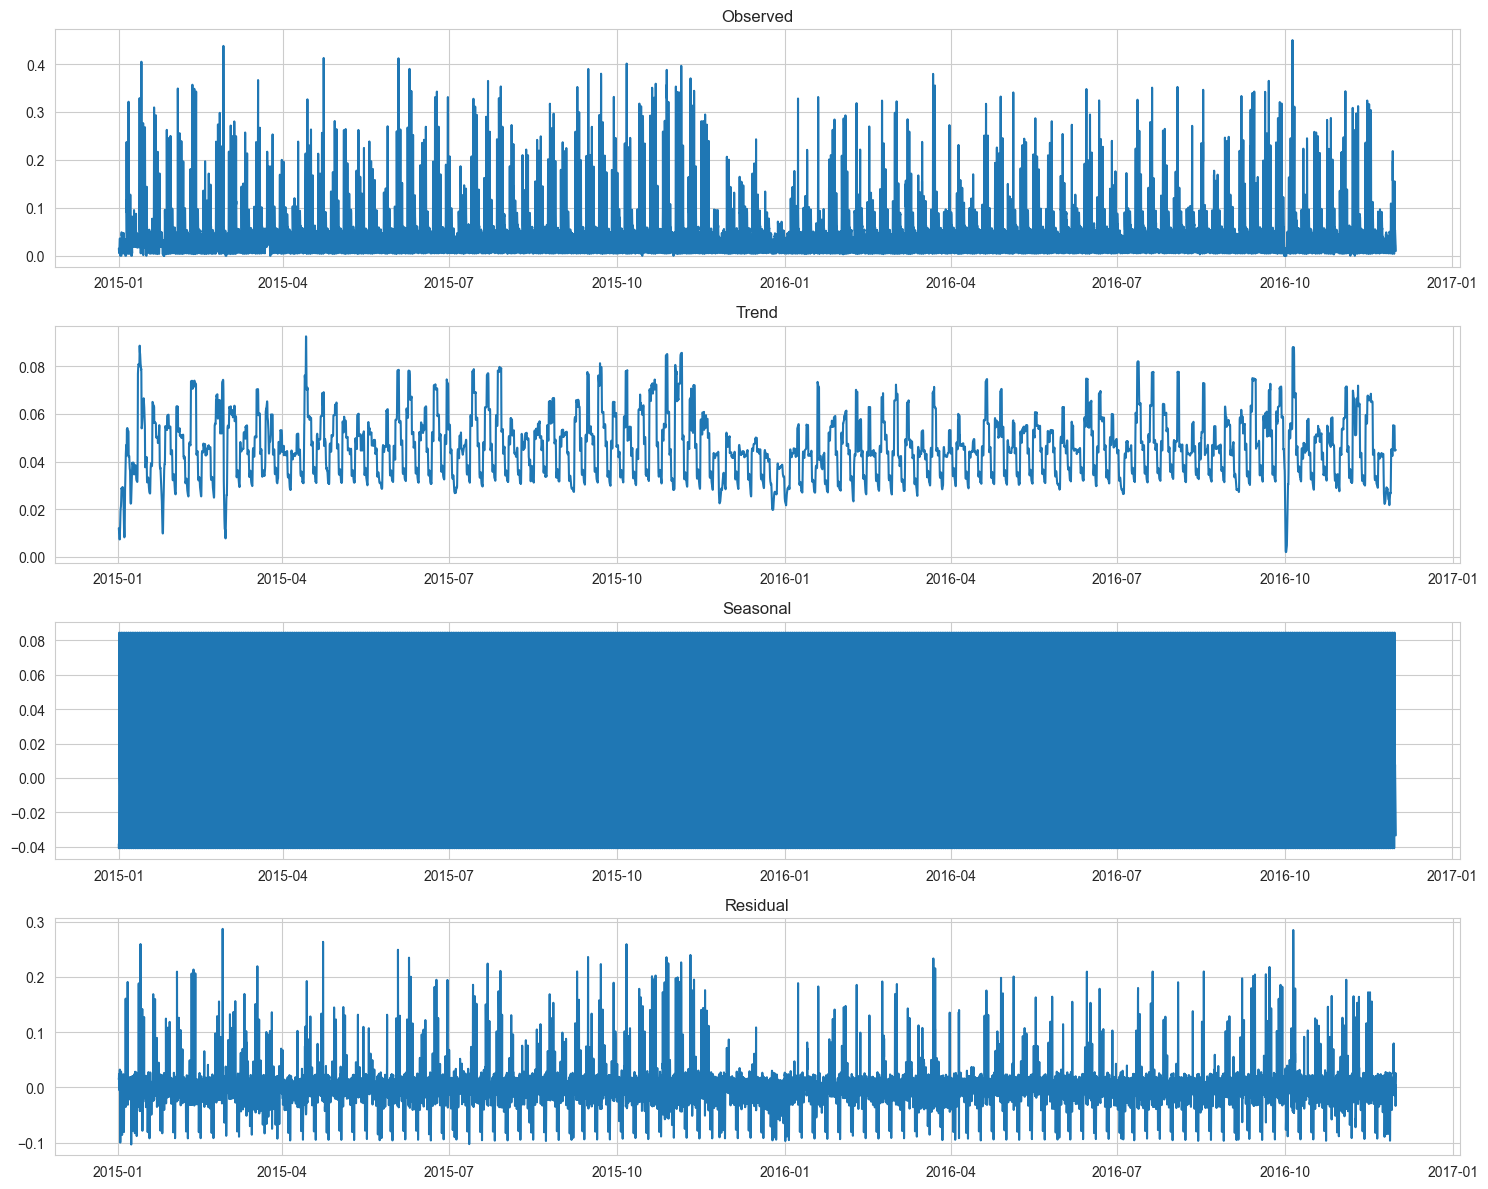

In [8]:
# Cell 6 - Statistical Analysis
def analyze_stationarity(series):
    """
    Perform stationarity analysis and seasonal decomposition
    """
    # Stationarity test
    print("=== Stationarity Analysis ===")
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # Seasonal decomposition
    decomposition = seasonal_decompose(series.dropna(), period=24)  # 24 hours for daily seasonality

    # Plot decomposition
    plt.figure(figsize=(15, 12))
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed')
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonal')
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residual')
    plt.tight_layout()
    plt.show()

    return decomposition

# Perform statistical analysis
decomposition = analyze_stationarity(df['X'])

=== Advanced Time Series Analysis ===

Analyzing multiple seasonality patterns...


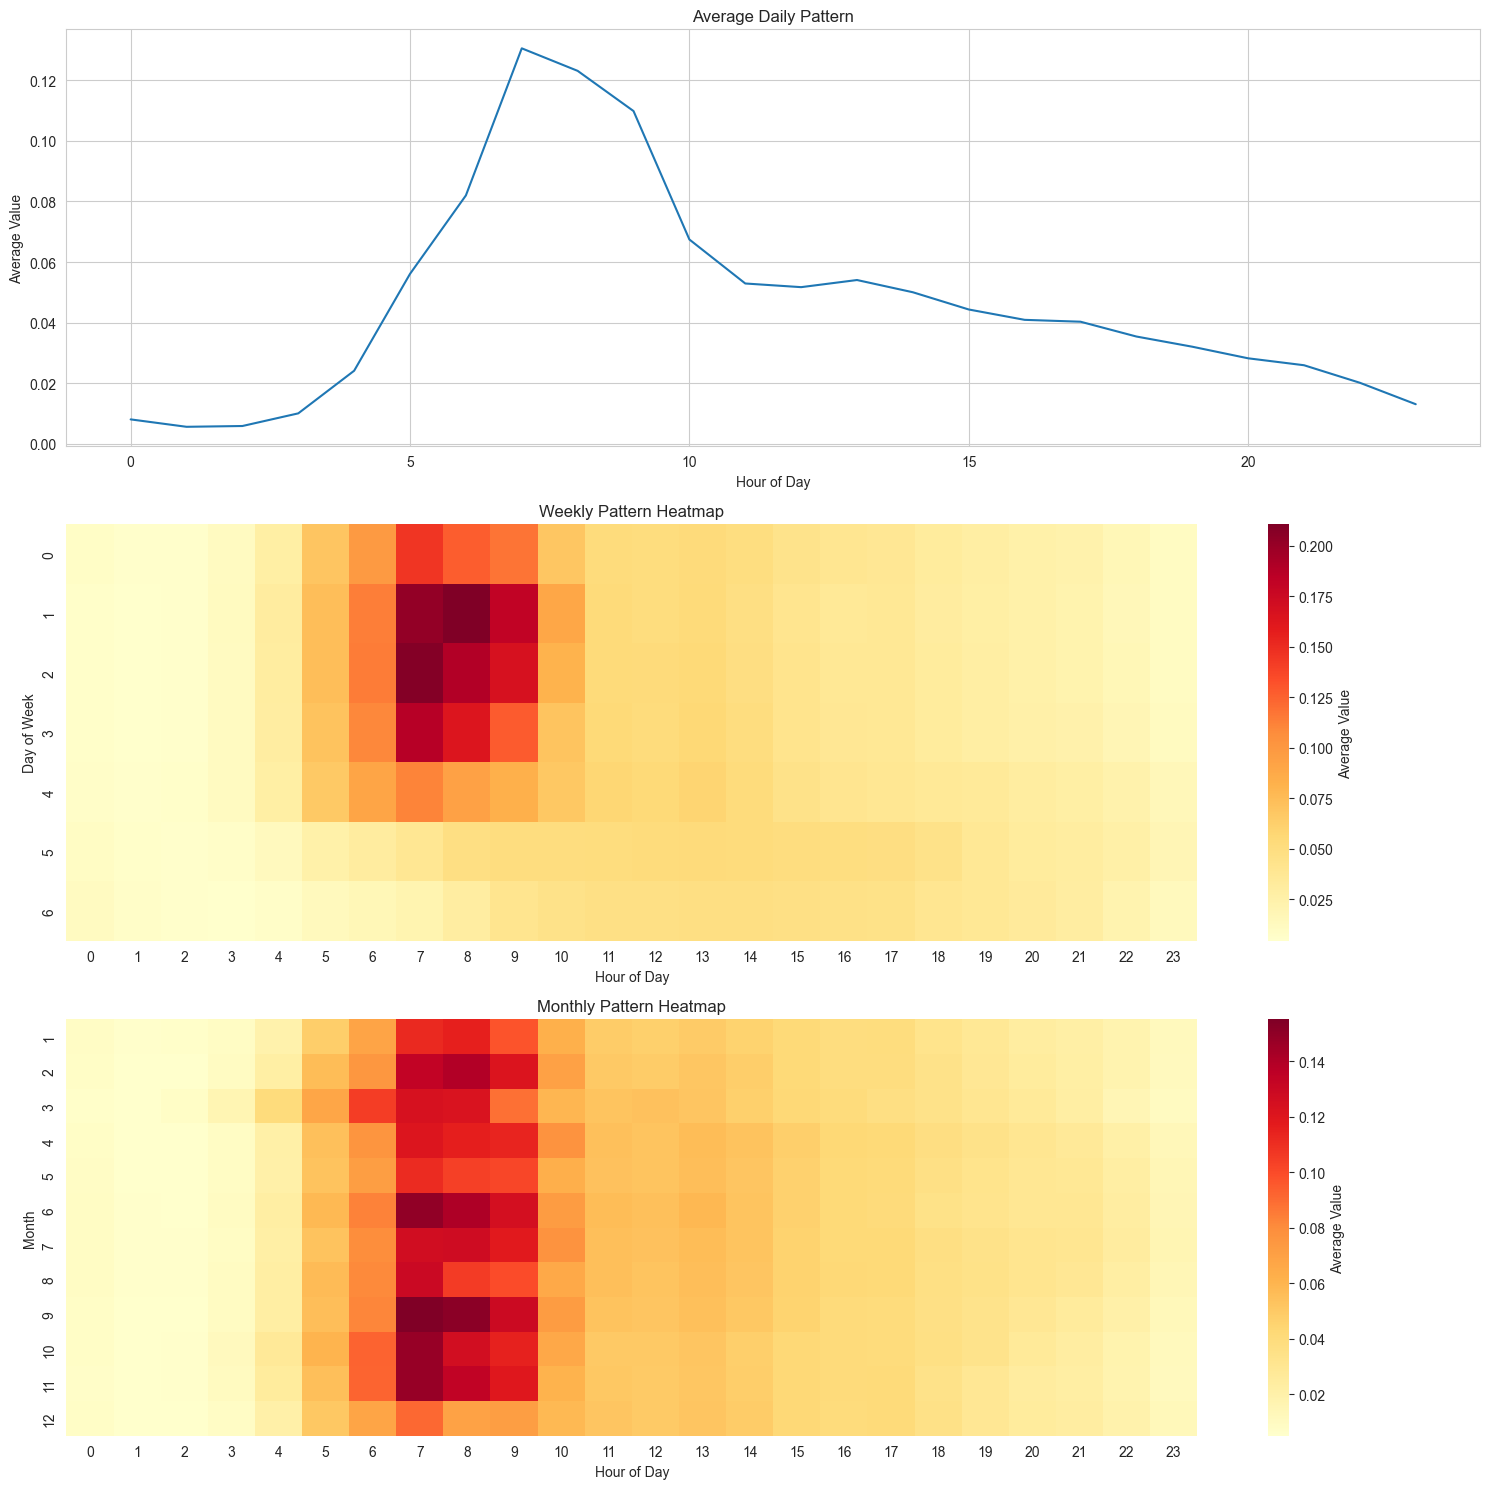

In [9]:
# Cell 7 - Advanced Time Series Analysis
print("=== Advanced Time Series Analysis ===")

def plot_acf_pacf(series, lags=40):
    """
    Plot ACF and PACF for the time series
    """
    plt.figure(figsize=(15, 10))
    
    # Plot ACF
    plt.subplot(211)
    plot_acf(series.dropna(), lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function')
    
    # Plot PACF
    plt.subplot(212)
    plot_pacf(series.dropna(), lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function')
    
    plt.tight_layout()
    plt.show()

def analyze_multiple_seasonality(df):
    """
    Analyze multiple seasonal patterns in the data
    """
    # Daily seasonality
    daily_pattern = df.groupby(df.index.hour)['X'].mean()
    
    # Weekly seasonality
    weekly_pattern = df.groupby([df.index.dayofweek, df.index.hour])['X'].mean()
    weekly_pattern = weekly_pattern.unstack()
    
    # Monthly seasonality
    monthly_pattern = df.groupby([df.index.month, df.index.hour])['X'].mean()
    monthly_pattern = monthly_pattern.unstack()
    
    # Plotting
    fig = plt.figure(figsize=(15, 15))
    
    # Daily pattern
    plt.subplot(311)
    daily_pattern.plot()
    plt.title('Average Daily Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Value')
    
    # Weekly pattern
    plt.subplot(312)
    sns.heatmap(weekly_pattern, cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
    plt.title('Weekly Pattern Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    
    # Monthly pattern
    plt.subplot(313)
    sns.heatmap(monthly_pattern, cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
    plt.title('Monthly Pattern Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Month')
    
    plt.tight_layout()
    plt.show()
    
    return daily_pattern, weekly_pattern, monthly_pattern

# Execute the functions
print("\nAnalyzing multiple seasonality patterns...")
daily_pattern, weekly_pattern, monthly_pattern = analyze_multiple_seasonality(df)



=== ACF and PACF Analysis of Original Series ===


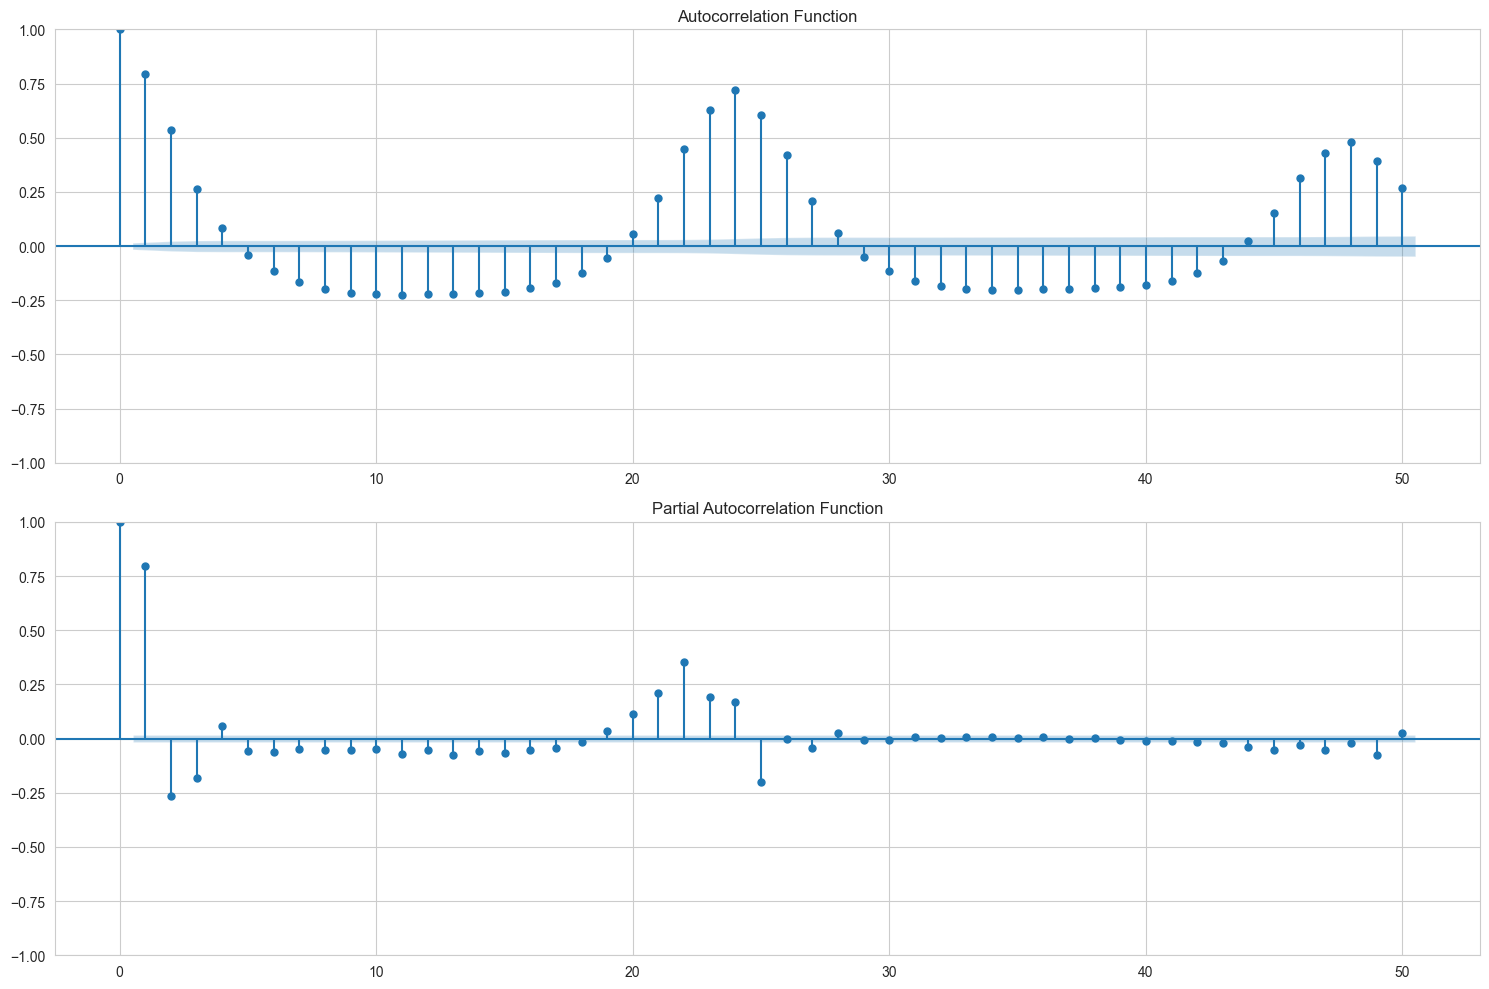


=== ACF and PACF Analysis of First Difference ===


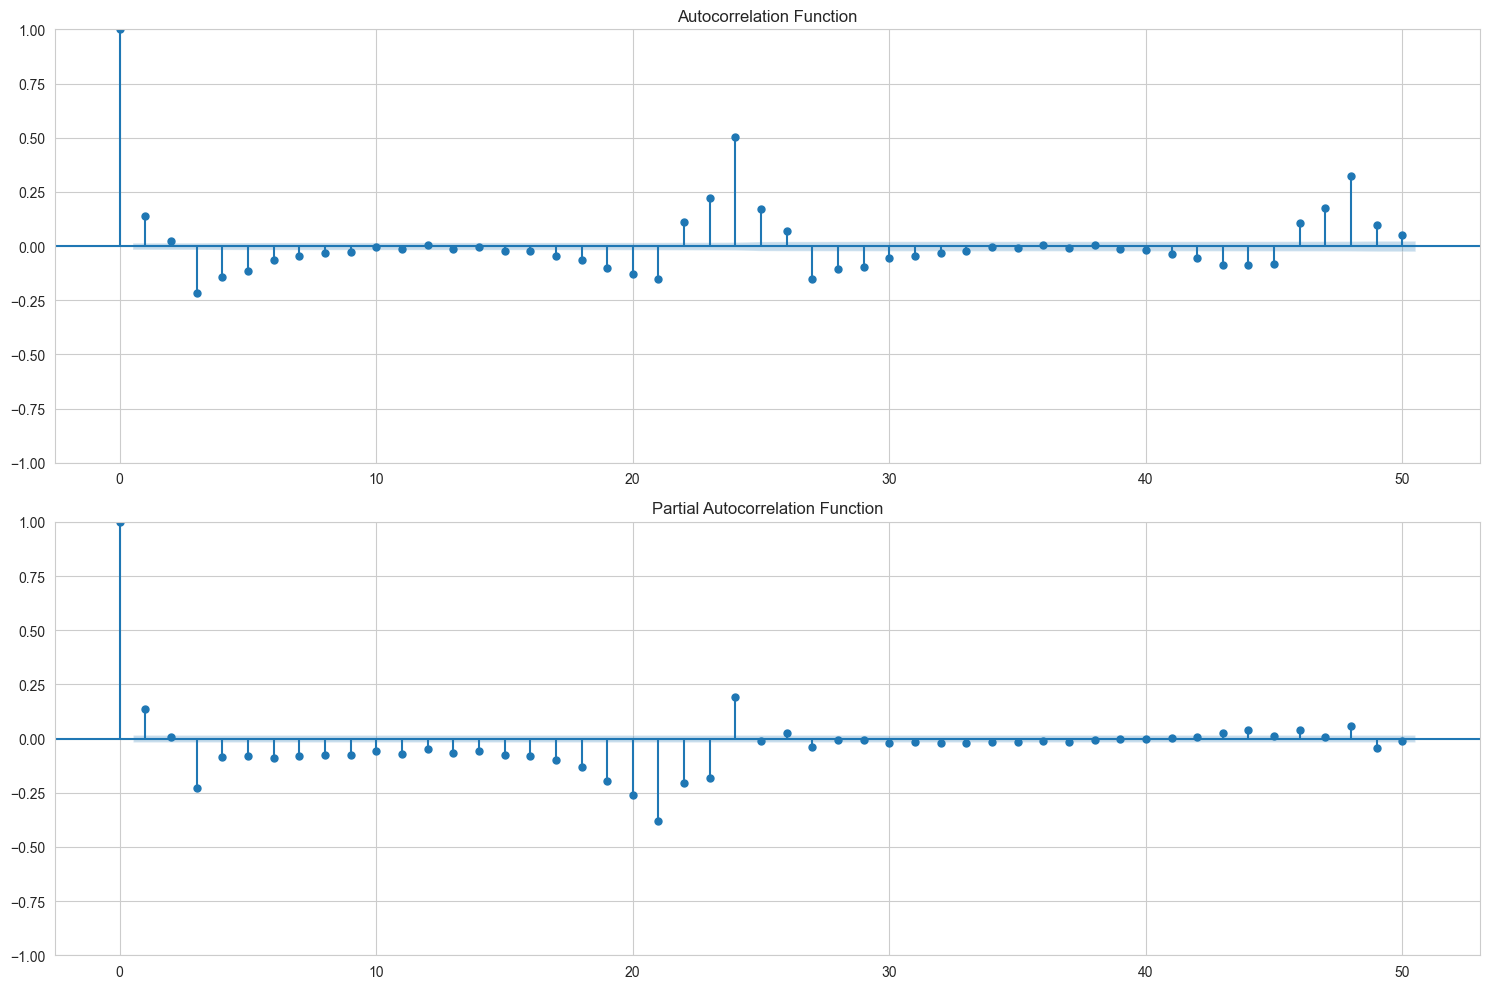


=== ACF and PACF Analysis of Seasonal Difference (24 hours) ===


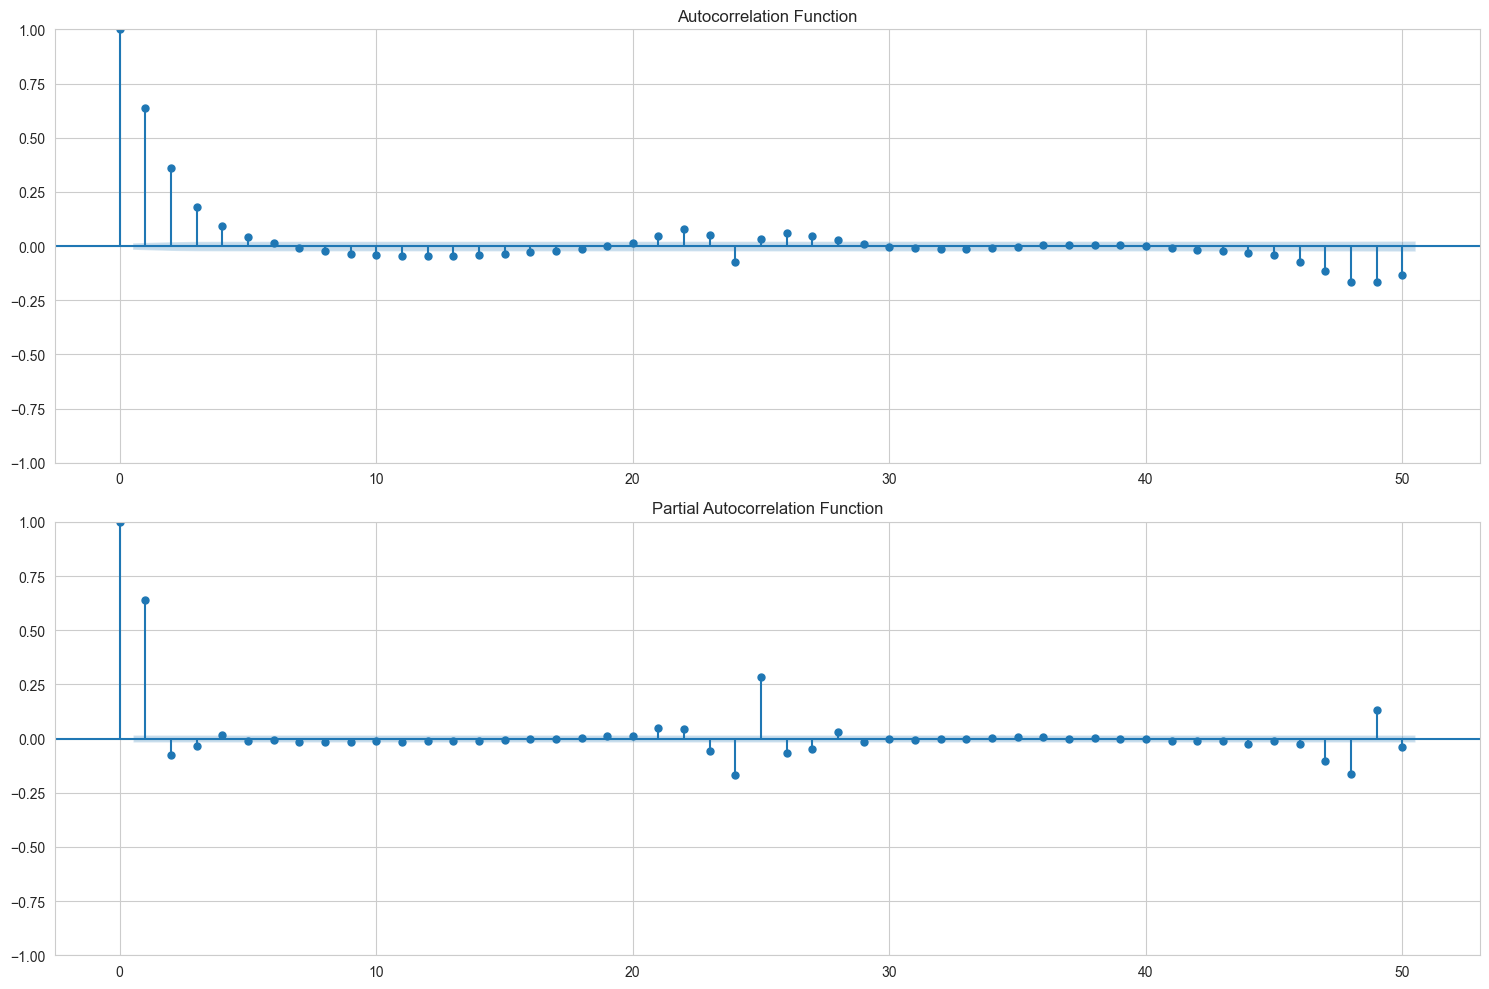


=== ACF and PACF Analysis of First and Seasonal Differences Combined ===


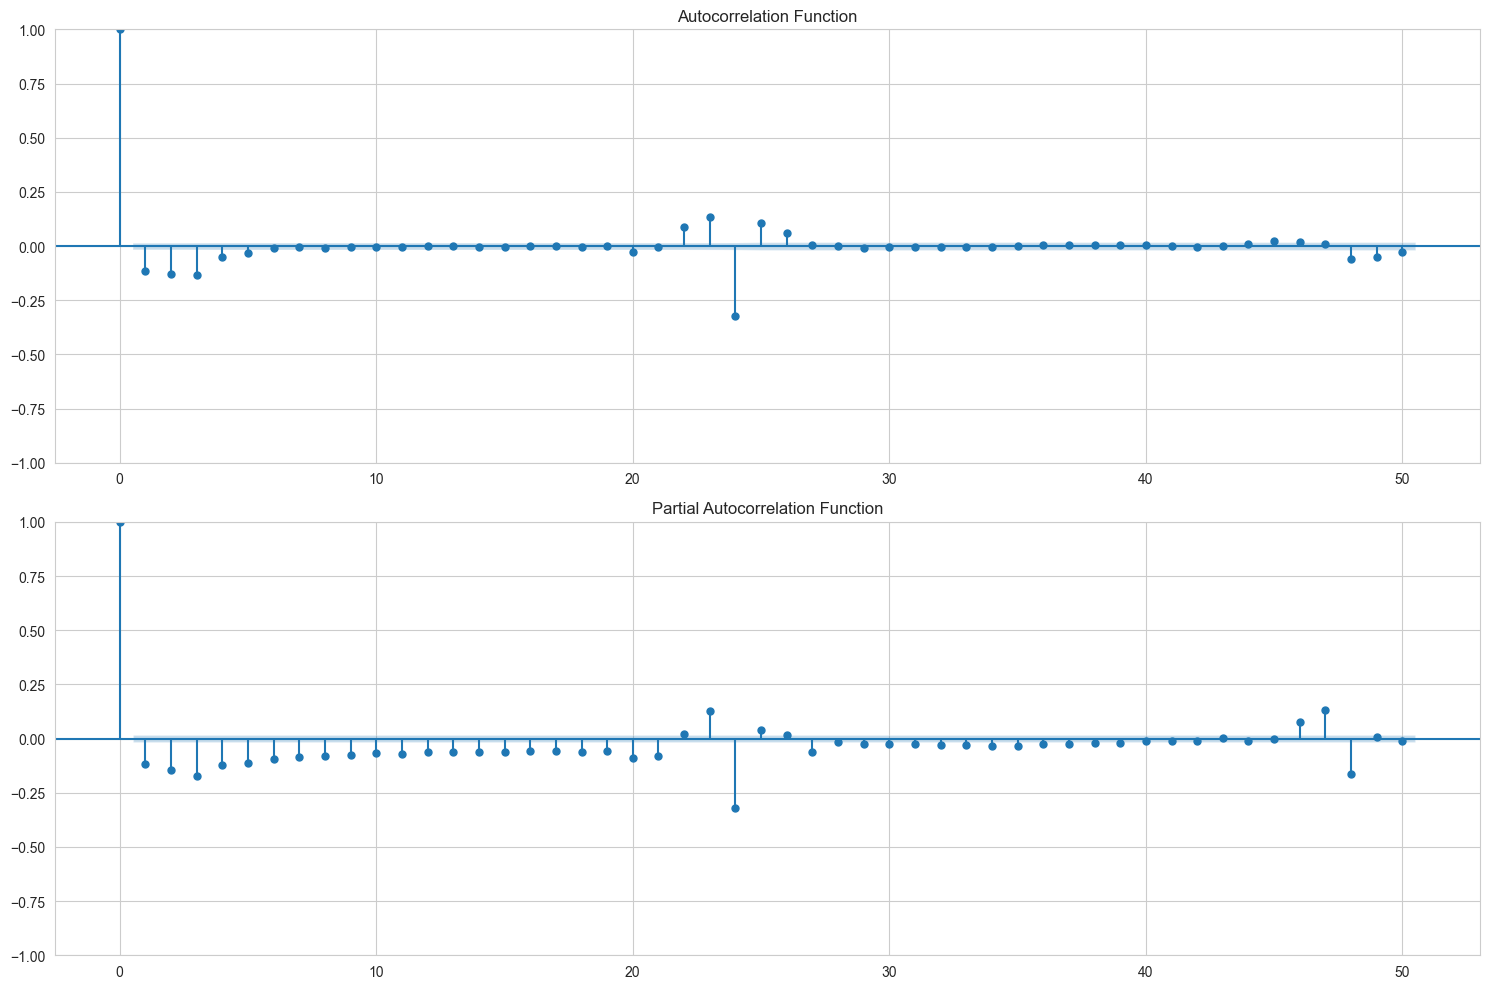


Statistics for Original Series:
Mean: 0.0463
Std: 0.0489
ADF Test p-value: 0.0000

Statistics for First Difference:
Mean: -0.0000
Std: 0.0313
ADF Test p-value: 0.0000

Statistics for Seasonal Difference:
Mean: 0.0000
Std: 0.0367
ADF Test p-value: 0.0000

Statistics for Both Differences:
Mean: 0.0000
Std: 0.0313
ADF Test p-value: 0.0000


In [10]:
# Cell 8 - ACF and PACF Analysis

# First, let's analyze the original series
print("=== ACF and PACF Analysis of Original Series ===")
plot_acf_pacf(df['X'], lags=50)

# Now let's look at first difference
print("\n=== ACF and PACF Analysis of First Difference ===")
diff1 = df['X'].diff().dropna()
plot_acf_pacf(diff1, lags=50)

# Let's also look at seasonal difference (24-hour seasonality)
print("\n=== ACF and PACF Analysis of Seasonal Difference (24 hours) ===")
seasonal_diff = df['X'].diff(24).dropna()
plot_acf_pacf(seasonal_diff, lags=50)

# And finally, both differences combined
print("\n=== ACF and PACF Analysis of First and Seasonal Differences Combined ===")
both_diff = seasonal_diff.diff().dropna()
plot_acf_pacf(both_diff, lags=50)

# Let's also show some statistics about each transformation
def print_series_stats(series, name):
    print(f"\nStatistics for {name}:")
    print(f"Mean: {series.mean():.4f}")
    print(f"Std: {series.std():.4f}")
    print(f"ADF Test p-value: {adfuller(series.dropna())[1]:.4f}")

print_series_stats(df['X'], "Original Series")
print_series_stats(diff1, "First Difference")
print_series_stats(seasonal_diff, "Seasonal Difference")
print_series_stats(both_diff, "Both Differences")

=== ACF and PACF Analysis of Original Series ===

Short-term patterns (2 days):


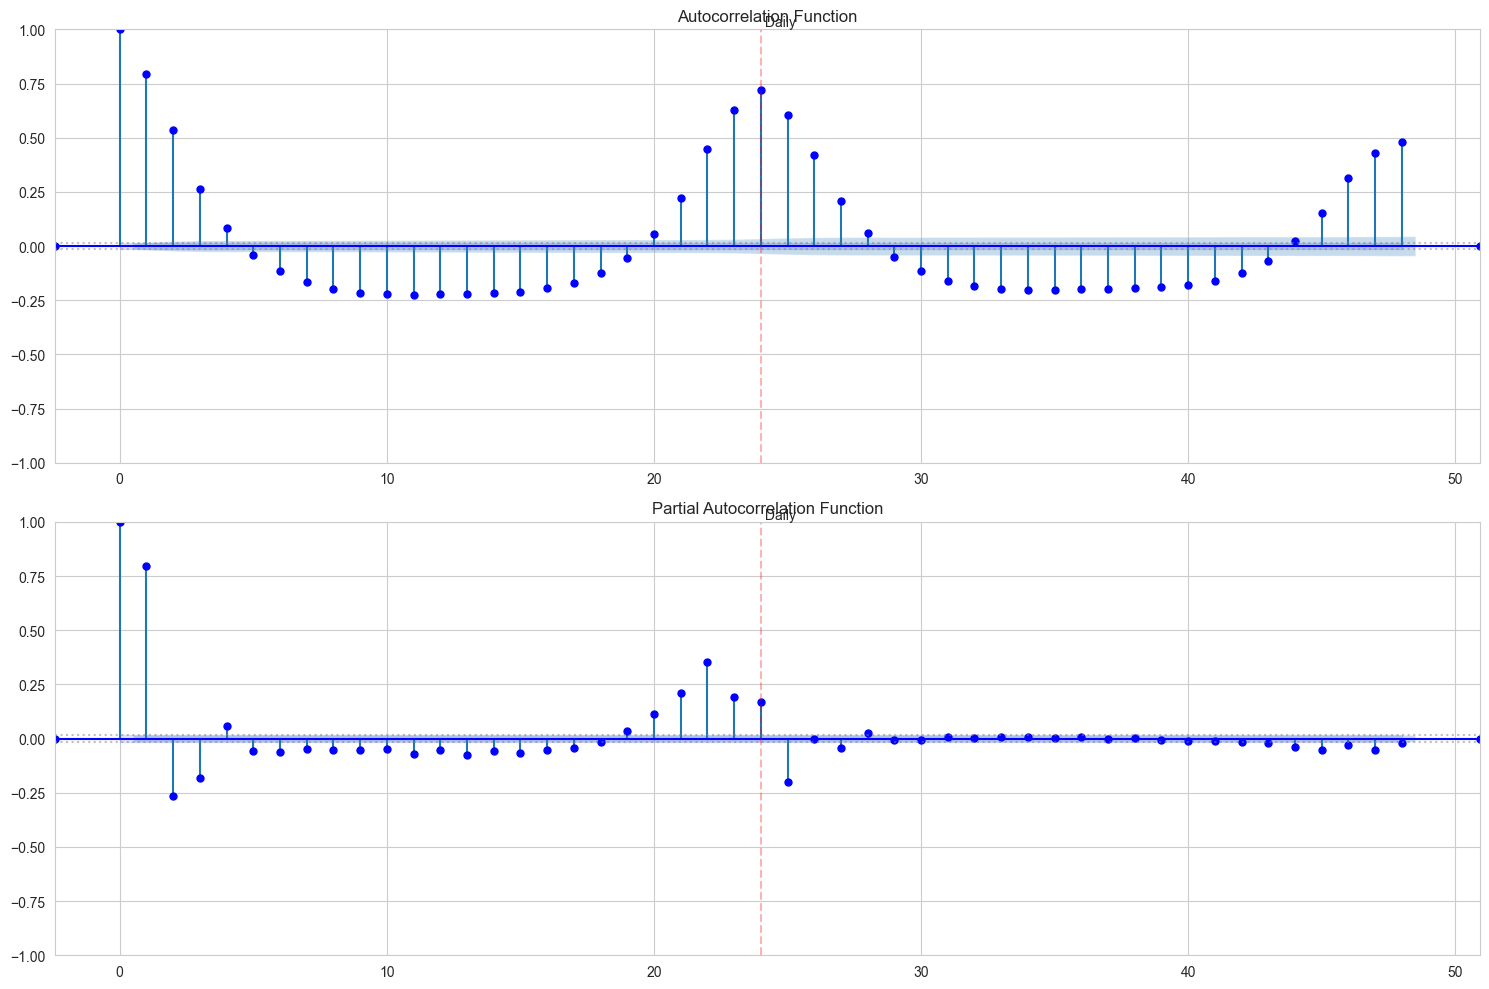


Medium-term patterns (2 weeks):


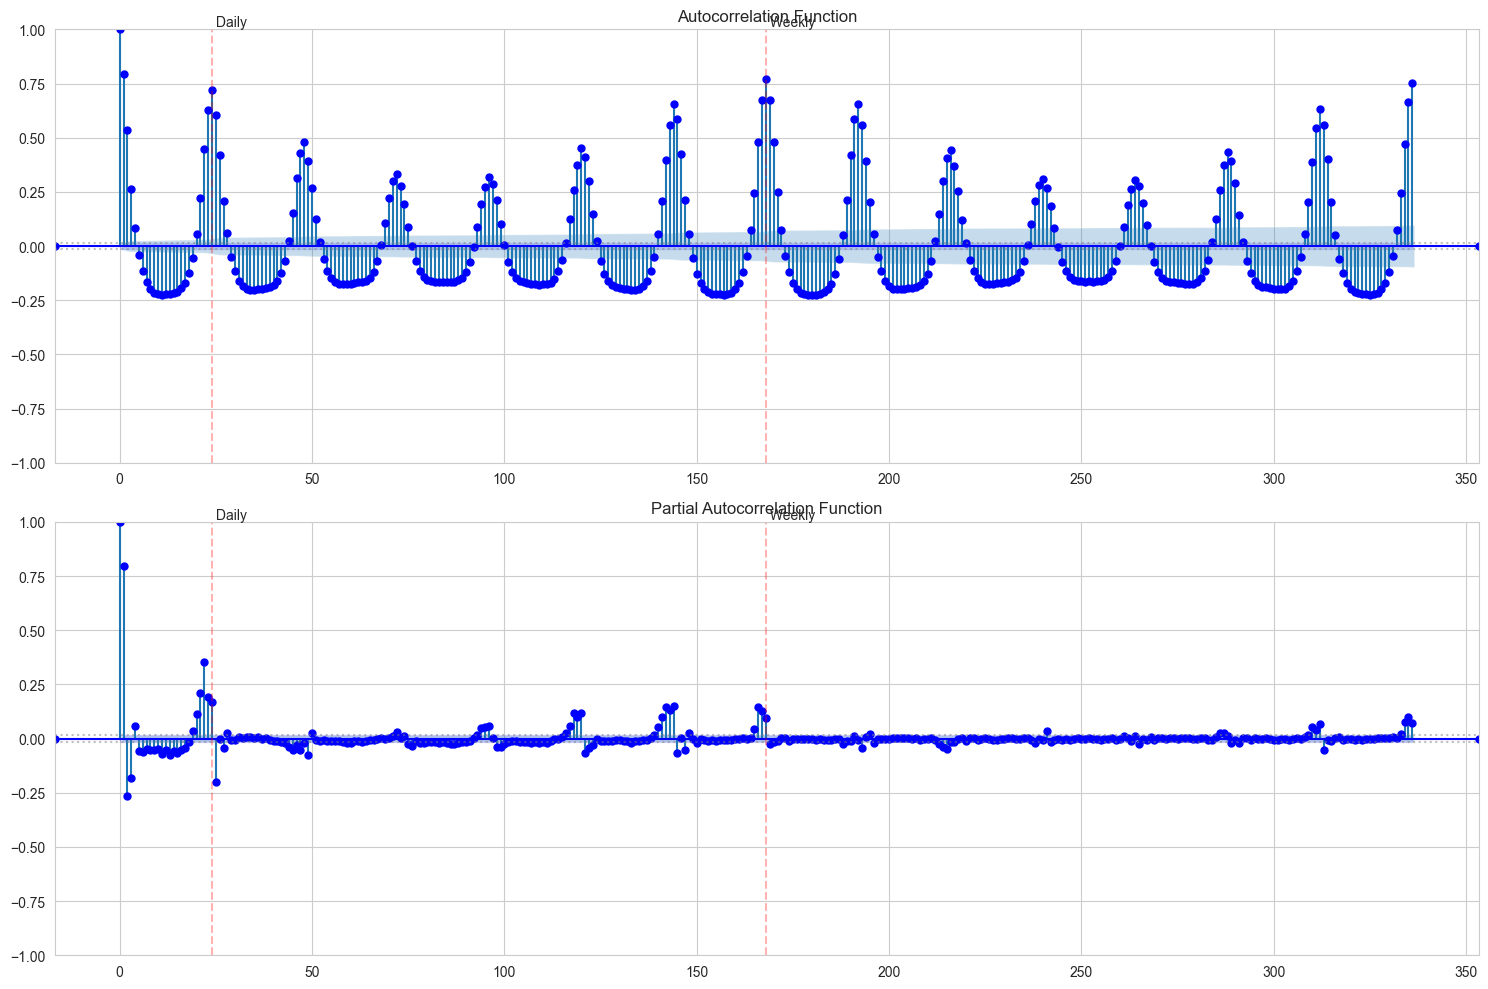


Long-term patterns (1 month):


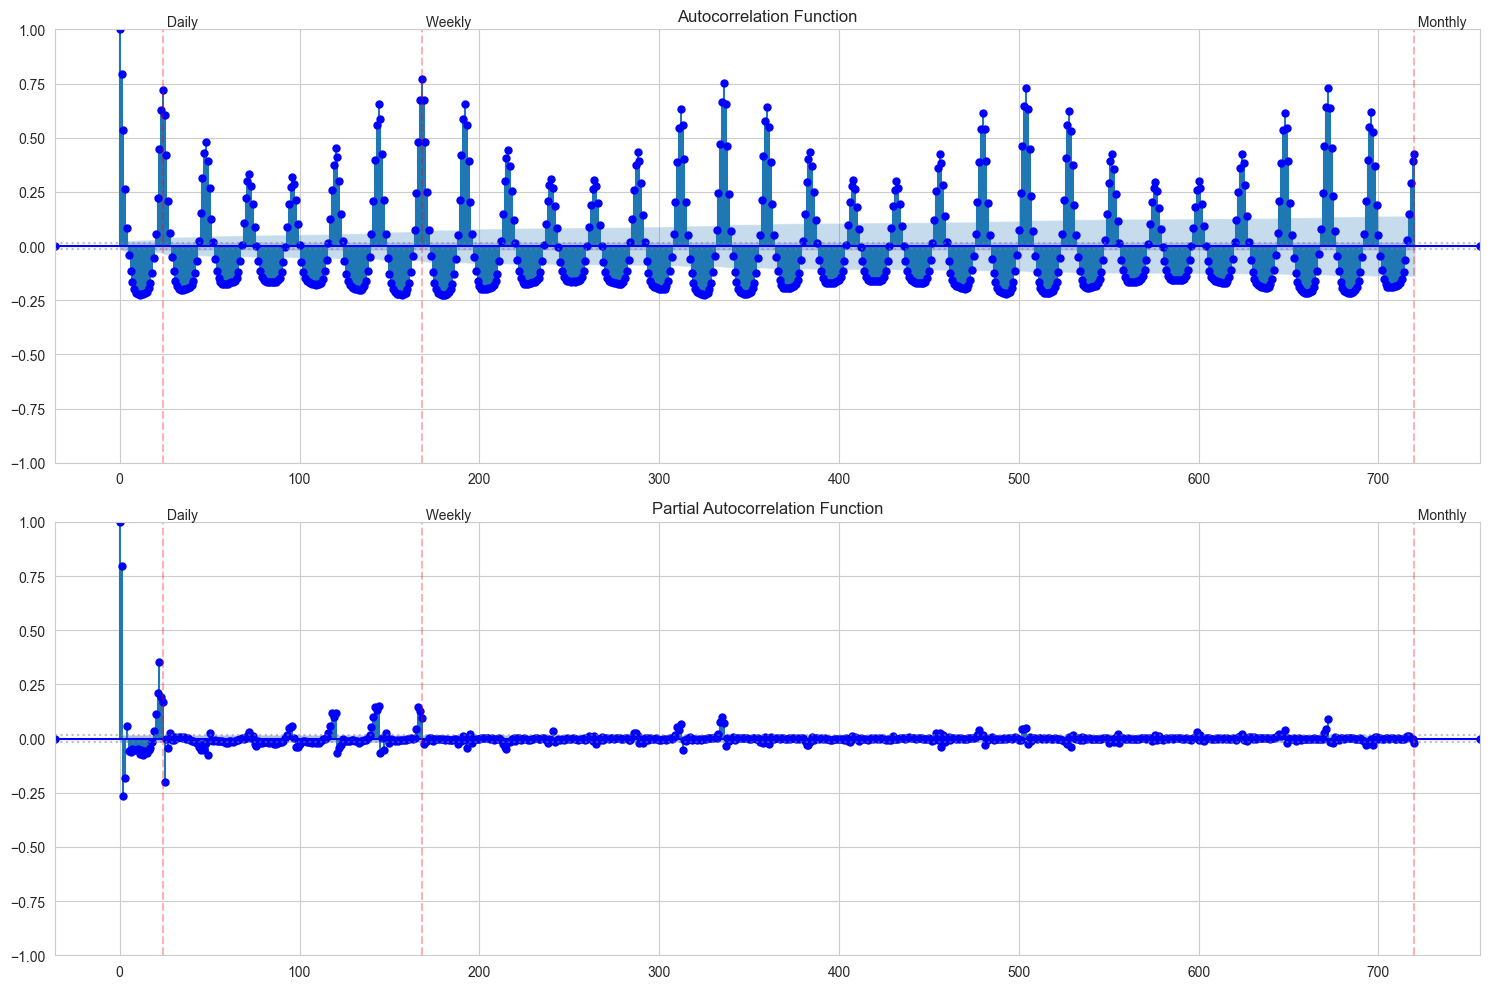


=== ACF and PACF Analysis of Differenced Series ===

First Difference:


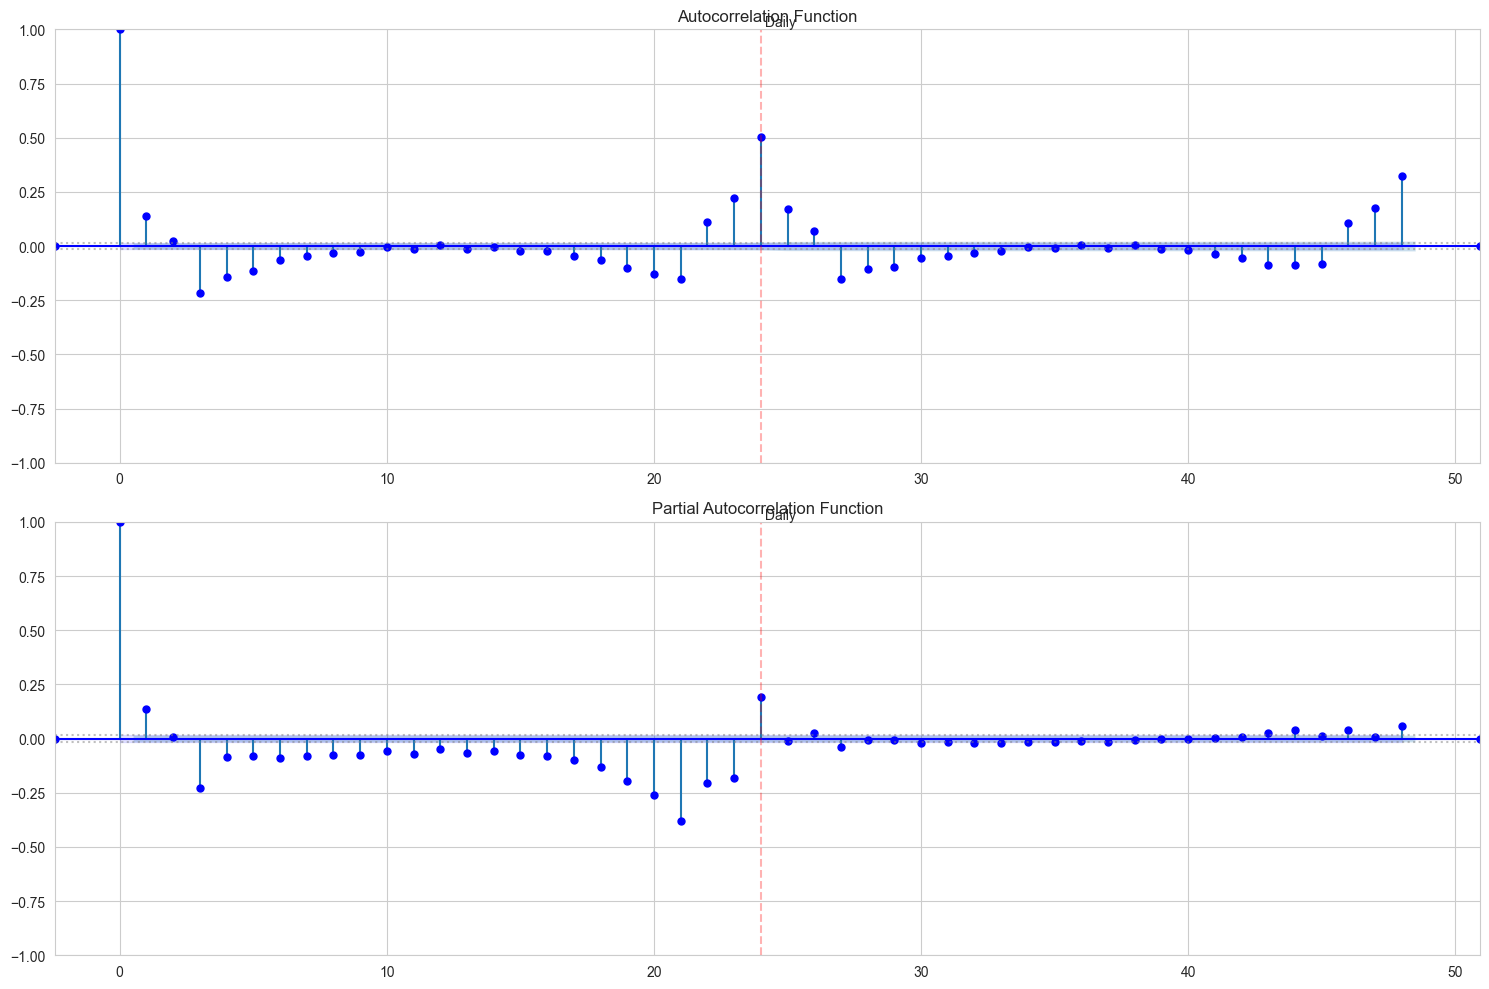


Seasonal Difference (24 hours):


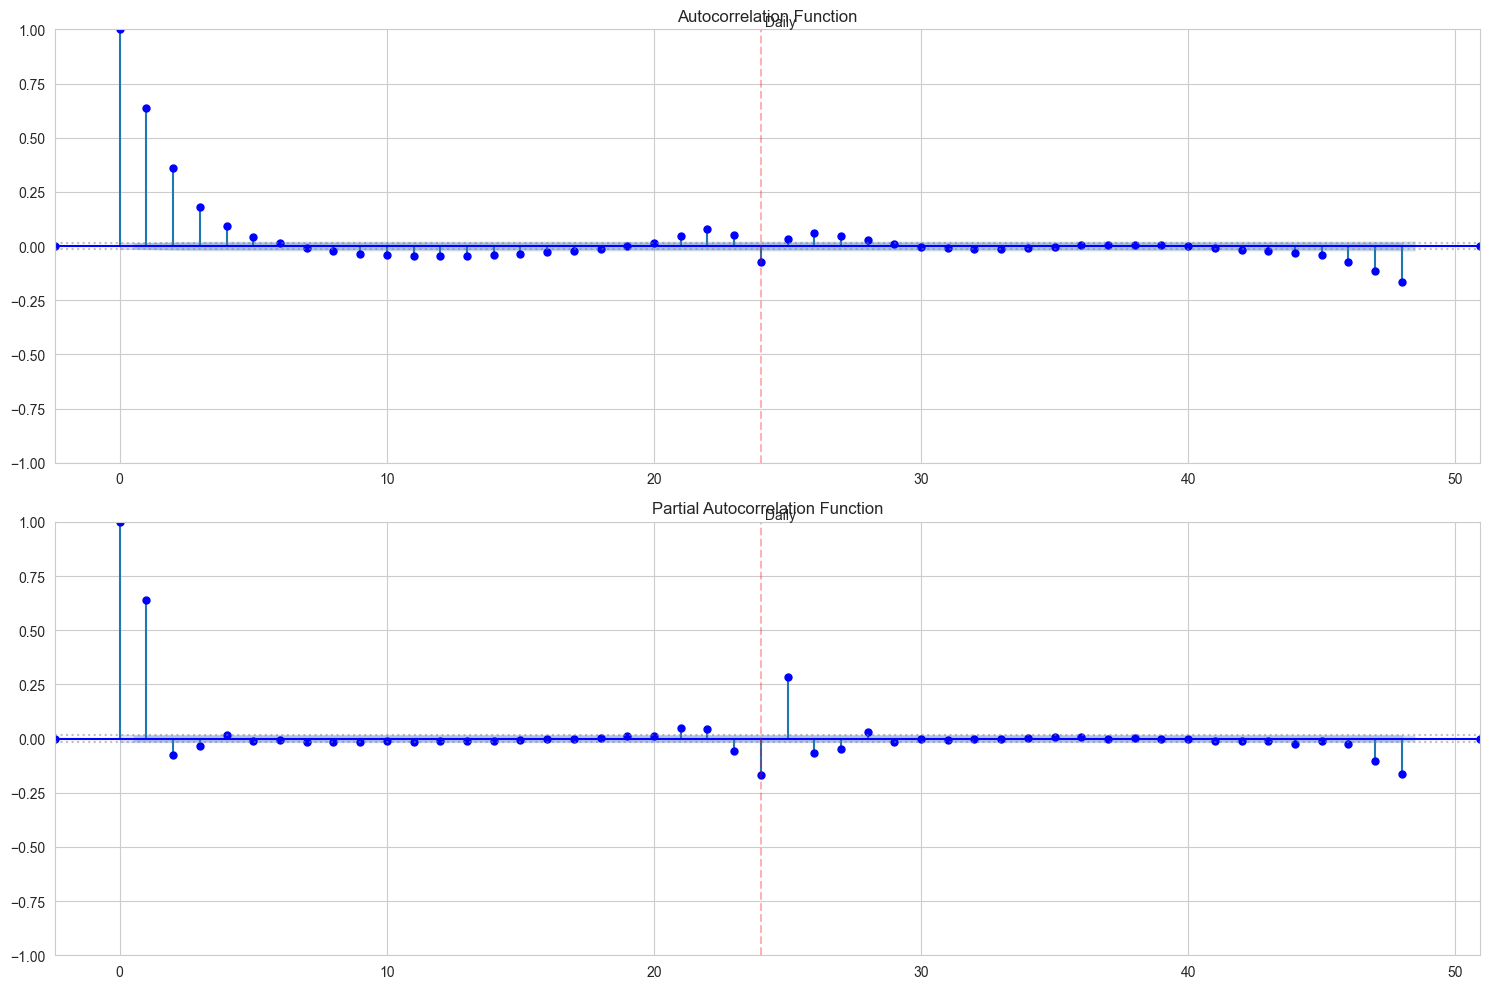


Both Differences Combined:


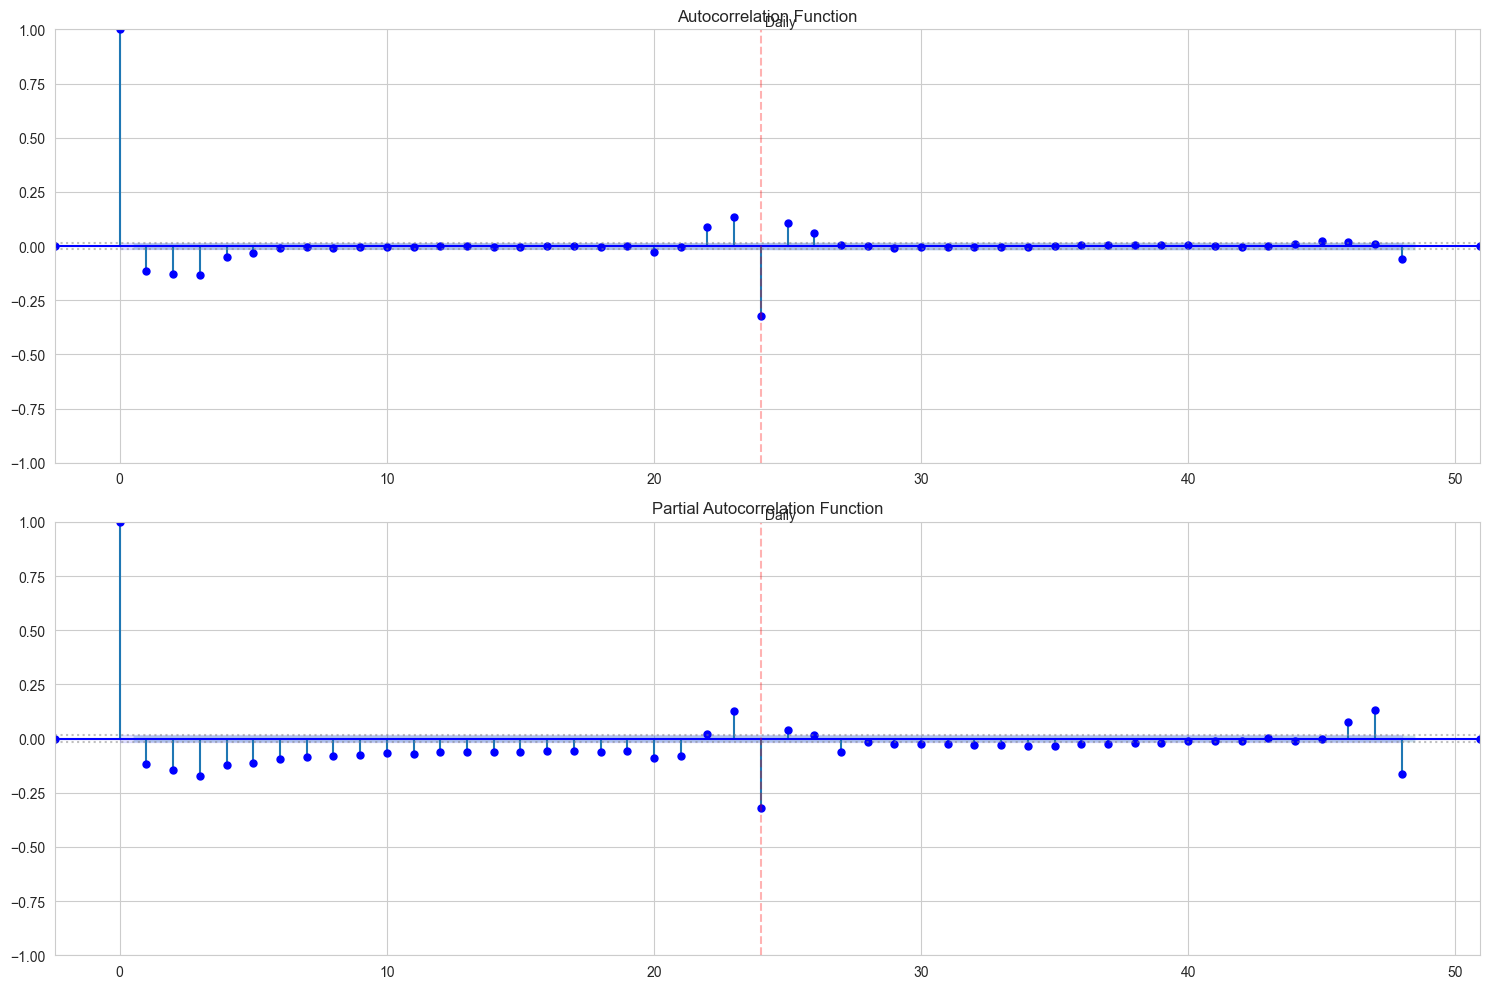

In [11]:
# Cell 9 - Updated ACF and PACF Analysis

def plot_advanced_acf_pacf(series, max_lags=None, periods=None):
    """
    Plot ACF and PACF with multiple lag ranges and highlighted seasonal periods
    
    Parameters:
    - series: time series data
    - max_lags: maximum number of lags to show
    - periods: list of tuples (period, label) to highlight
    """
    if max_lags is None:
        max_lags = 24 * 8  # Show 8 days by default
    
    if periods is None:
        periods = [
            (24, "Daily"),
            (24 * 7, "Weekly"),
            (24 * 30, "Monthly")
        ]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot ACF
    plot_acf(series.dropna(), lags=max_lags, ax=ax1, alpha=0.05, 
            markersize=5, c='blue', marker='o')
    ax1.set_title('Autocorrelation Function')
    
    # Plot PACF
    plot_pacf(series.dropna(), lags=max_lags, ax=ax2, alpha=0.05, 
             markersize=5, c='blue', marker='o')
    ax2.set_title('Partial Autocorrelation Function')
    
    # Add vertical lines for seasonal periods
    for period, label in periods:
        if period <= max_lags:
            for ax in [ax1, ax2]:
                ax.axvline(x=period, color='red', linestyle='--', alpha=0.3)
                ax.text(period, ax.get_ylim()[1], f' {label}', 
                       rotation=0, verticalalignment='bottom')
    
    # Enhance confidence intervals visibility
    for ax in [ax1, ax2]:
        # Get the confidence intervals (approximately at y = ±2/√T)
        ci = 2/np.sqrt(len(series))
        ax.axhline(y=ci, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=-ci, color='gray', linestyle=':', alpha=0.5)
        ax.fill_between(range(max_lags + 1), -ci, ci, color='blue', alpha=0.1)
    
    plt.tight_layout()
    plt.show()

# Plot for different ranges
print("=== ACF and PACF Analysis of Original Series ===")
print("\nShort-term patterns (2 days):")
plot_advanced_acf_pacf(df['X'], max_lags=48)

print("\nMedium-term patterns (2 weeks):")
plot_advanced_acf_pacf(df['X'], max_lags=24*14)

print("\nLong-term patterns (1 month):")
plot_advanced_acf_pacf(df['X'], max_lags=24*30)

# Also show the differenced series
print("\n=== ACF and PACF Analysis of Differenced Series ===")
diff1 = df['X'].diff().dropna()
seasonal_diff = df['X'].diff(24).dropna()
both_diff = seasonal_diff.diff().dropna()

print("\nFirst Difference:")
plot_advanced_acf_pacf(diff1, max_lags=48)

print("\nSeasonal Difference (24 hours):")
plot_advanced_acf_pacf(seasonal_diff, max_lags=48)

print("\nBoth Differences Combined:")
plot_advanced_acf_pacf(both_diff, max_lags=48)

# ARIMA Simple

In [12]:
# Cell 10 - Common Data Preparation
from tqdm import tqdm  # For progress bars

def prepare_data_for_modeling(df, forecast_horizon=744):
    """
    Prepare data for modeling (common across all models)
    """
    print("=== Data Preparation ===")

    # Remove the last forecast_horizon hours (target forecast period)
    train_data = df[df['X'].notna()].copy()

    # Create validation set (last month of available data)
    validation_size = forecast_horizon
    train_set = train_data[:-validation_size]
    val_set = train_data[-validation_size:]

    print("\nData Split Summary:")
    print(f"Training set: {train_set.index.min()} to {train_set.index.max()}")
    print(f"Validation set: {val_set.index.min()} to {val_set.index.max()}")
    print(f"Forecast period: {val_set.index.max() + pd.Timedelta(hours=1)} to {df.index.max()}")

    return train_set, val_set

# Prepare the data
train_set, val_set = prepare_data_for_modeling(df)

=== Data Preparation ===

Data Split Summary:
Training set: 2015-01-01 00:00:00 to 2016-10-30 23:00:00
Validation set: 2016-10-31 00:00:00 to 2016-11-30 23:00:00
Forecast period: 2016-12-01 00:00:00 to 2016-12-31 23:00:00


In [13]:
# Cell 11 - ARIMA Model Development and Training
def develop_arima_model(train_data):
    """
    Develop ARIMA model based on theoretical analysis
    """
    print("=== ARIMA Model Development ===")

    # Convert to pandas Series with frequency and handle any preprocessing
    y = train_data['X'].astype(float)
    y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
    # Define more conservative models
    models_to_try = [
        ((1,1,1), (0,1,1,24)),    # Simple model with seasonal MA only
        ((1,1,1), (1,1,0,24)),    # Simple model with seasonal AR only
        ((2,1,2), (1,1,1,24)),    # More complex model
        ((0,1,1), (0,1,1,24))     # Airline model (often works well)
    ]

    best_aic = float('inf')
    best_model = None
    best_order = None
    best_seasonal_order = None

    print("\nTrying specific model configurations...")
    for order, seasonal_order in tqdm(models_to_try, desc="Testing Models"):
        try:
            print(f"\nFitting ARIMA{order}{seasonal_order}")
            
            # Add start_params to help convergence
            model = ARIMA(y,
                         order=order,
                         seasonal_order=seasonal_order,
                         enforce_stationarity=False,
                         enforce_invertibility=True)  # Changed to True

            # Use conditional sum of squares to start
            results = model.fit(method='innovations_mle')
            current_aic = results.aic
            
            print(f"AIC: {current_aic:.2f}")
            
            # Check if the model is reasonable (non-flat forecast)
            test_forecast = results.forecast(steps=24)
            forecast_std = test_forecast.std()
            
            # Only consider model if forecasts show variation
            if forecast_std > 0.001 and current_aic < best_aic:
                best_aic = current_aic
                best_model = results
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            print(f"Error fitting ARIMA{order}{seasonal_order}:")
            print(f"Error message: {str(e)}")
            continue

    if best_model is None:
        raise ValueError("No models were successfully fitted!")

    print("\nBest Model Configuration:")
    print(f"Order: {best_order}")
    print(f"Seasonal Order: {best_seasonal_order}")
    print(f"AIC: {best_aic}")
    print("\nModel Summary:")
    print(best_model.summary())

    return best_model, best_order, best_seasonal_order

In [14]:
# Cell 12 - ARIMA Model Diagnostics
def perform_arima_diagnostics(model):
    """
    Perform diagnostic tests for ARIMA model
    """
    print("=== ARIMA Model Diagnostics ===")

    residuals = model.resid
    
    # Create diagnostic plots
    fig = plt.figure(figsize=(15, 15))

    # 1. Residuals over time
    ax1 = plt.subplot(411)
    plt.plot(residuals.index, residuals, 'b.', alpha=0.5, markersize=2)
    plt.plot(residuals.index, pd.Series(0, index=residuals.index), 'r--')
    plt.title('Residuals over Time')
    plt.grid(True, alpha=0.2)

    # 2. ACF of residuals
    ax2 = plt.subplot(412)
    plot_acf(residuals, lags=50, ax=ax2, alpha=0.05,
             title="ACF of Residuals",
             markersize=3)
    plt.grid(True, alpha=0.2)

    # 3. PACF of residuals
    ax3 = plt.subplot(413)
    plot_pacf(residuals, lags=50, ax=ax3, alpha=0.05,
              title="PACF of Residuals",
              markersize=3)
    plt.grid(True, alpha=0.2)

    # 4. Q-Q plot
    ax4 = plt.subplot(414)
    stats.probplot(residuals, dist="norm", plot=plt)
    ax4.set_title("Q-Q plot of residuals")
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nResidual Statistics:")
    print(f"Mean: {residuals.mean():.4f}")
    print(f"Std Dev: {residuals.std():.4f}")
    print(f"Skewness: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

In [15]:
# Cell 13 - ARIMA Forecasting (with non-negative constraints)
def generate_arima_forecasts(model, train_data, val_data, forecast_horizon=744):
    """
    Generate and evaluate ARIMA forecasts with non-negative constraints
    """
    print("=== ARIMA Forecasting ===")

    # In-sample predictions
    in_sample_pred = model.get_prediction(start=0)
    in_sample_mean = np.maximum(in_sample_pred.predicted_mean, 0)  # Force non-negative

    # Validation set predictions
    val_pred = model.get_prediction(
        start=len(train_data), 
        end=len(train_data)+len(val_data)-1,
        dynamic=False
    )
    val_mean = np.maximum(val_pred.predicted_mean, 0)  # Force non-negative
    val_conf = val_pred.conf_int()
    val_conf.iloc[:, 0] = np.maximum(val_conf.iloc[:, 0], 0)  # Force non-negative lower bound

    # Future forecasts
    forecast = model.get_forecast(
        steps=forecast_horizon,
        alpha=0.05
    )
    forecast_mean = np.maximum(forecast.predicted_mean, 0)  # Force non-negative
    forecast_conf = forecast.conf_int()
    forecast_conf.iloc[:, 0] = np.maximum(forecast_conf.iloc[:, 0], 0)  # Force non-negative lower bound

    # Plot results
    plt.figure(figsize=(15, 10))

    # Plot training data
    plt.plot(train_data.index, train_data['X'], label='Training Data', alpha=0.7)

    # Plot validation data
    plt.plot(val_data.index, val_data['X'], label='Validation Data', color='green', alpha=0.7)

    # Plot validation predictions
    plt.plot(val_data.index, val_mean, label='Validation Predictions', color='red', linestyle='--')
    plt.fill_between(val_data.index,
                     val_conf.iloc[:, 0],
                     val_conf.iloc[:, 1],
                     color='red', alpha=0.1)

    # Plot forecasts
    forecast_index = pd.date_range(start=val_data.index[-1] + pd.Timedelta(hours=1),
                                 periods=forecast_horizon,
                                 freq='H')
    plt.plot(forecast_index, forecast_mean, label='ARIMA Forecasts', color='blue')
    plt.fill_between(forecast_index,
                     forecast_conf.iloc[:, 0],
                     forecast_conf.iloc[:, 1],
                     color='blue', alpha=0.1)

    plt.title('ARIMA Model Forecasts')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate error metrics (using non-negative predictions)
    val_rmse = np.sqrt(mean_squared_error(val_data['X'], val_mean))
    val_mae = mean_absolute_error(val_data['X'], val_mean)
    val_mape = np.mean(np.abs((val_data['X'] - val_mean) / val_data['X'])) * 100

    print("\nValidation Set Metrics:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"MAE: {val_mae:.4f}")
    print(f"MAPE: {val_mape:.4f}%")

    return forecast_mean, forecast_conf, val_mean, val_conf

Starting ARIMA modeling pipeline...
=== ARIMA Model Development ===

Trying specific model configurations...


Testing Models:   0%|          | 0/4 [00:00<?, ?it/s]


Fitting ARIMA(1, 1, 1)(0, 1, 1, 24)


Testing Models:  25%|██▌       | 1/4 [00:12<00:36, 12.31s/it]

AIC: -73516.91

Fitting ARIMA(1, 1, 1)(1, 1, 0, 24)


Testing Models:  50%|█████     | 2/4 [00:16<00:14,  7.36s/it]

AIC: -69838.60

Fitting ARIMA(2, 1, 2)(1, 1, 1, 24)
AIC: -75161.10


Testing Models:  75%|███████▌  | 3/4 [00:54<00:21, 21.53s/it]


Fitting ARIMA(0, 1, 1)(0, 1, 1, 24)


Testing Models: 100%|██████████| 4/4 [00:59<00:00, 14.86s/it]

AIC: -71106.10

Best Model Configuration:
Order: (2, 1, 2)
Seasonal Order: (1, 1, 1, 24)
AIC: -75161.10112524132

Model Summary:


                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37587.551
Date:                            Fri, 10 Jan 2025   AIC                         -75161.101
Time:                                    09:44:52   BIC                         -75107.337
Sample:                                01-01-2015   HQIC                        -75143.319
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0280      0.055     18.858      0.000       0.921       1.135
ar.L2         -0.2997      0.038   

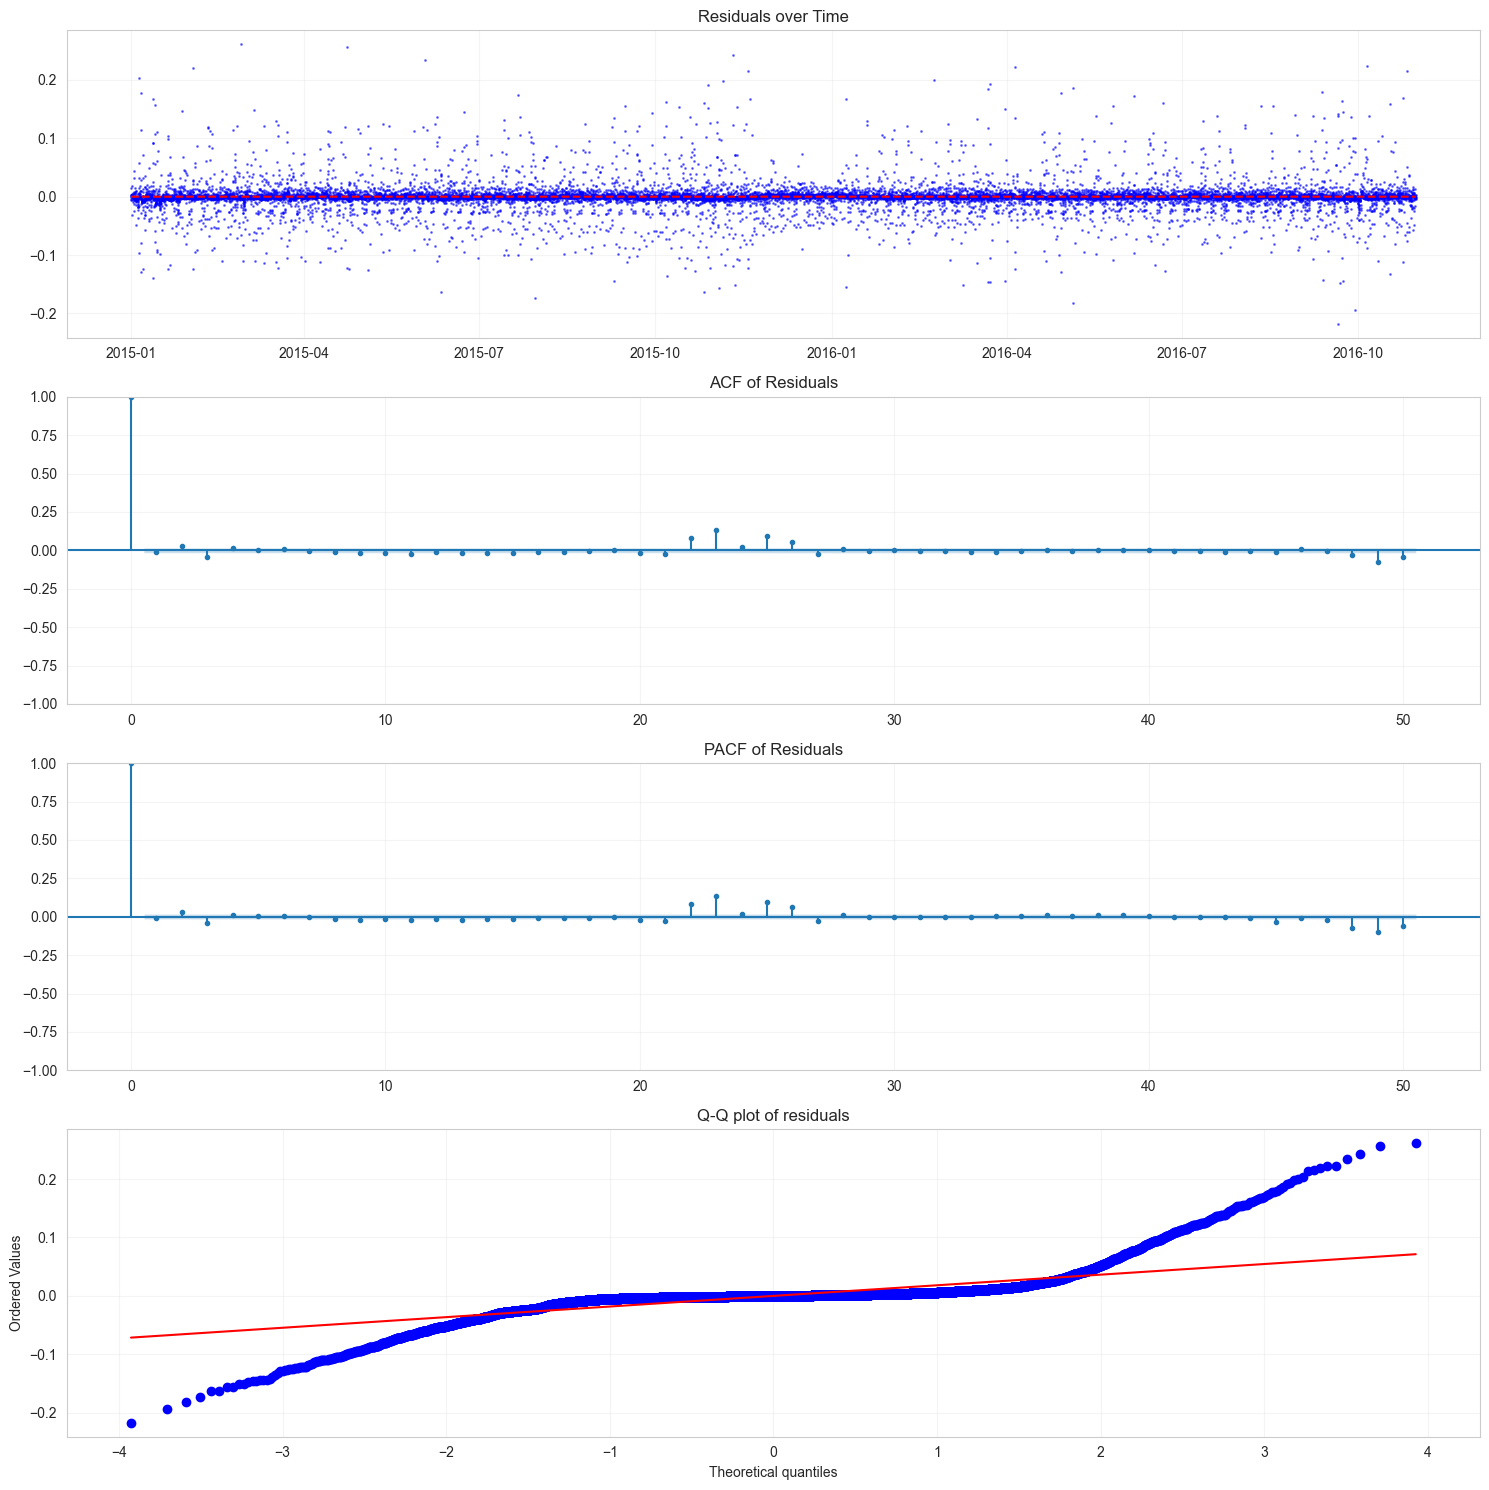


Residual Statistics:
Mean: -0.0001
Std Dev: 0.0231
Skewness: 1.2972
Kurtosis: 22.1946
=== ARIMA Forecasting ===


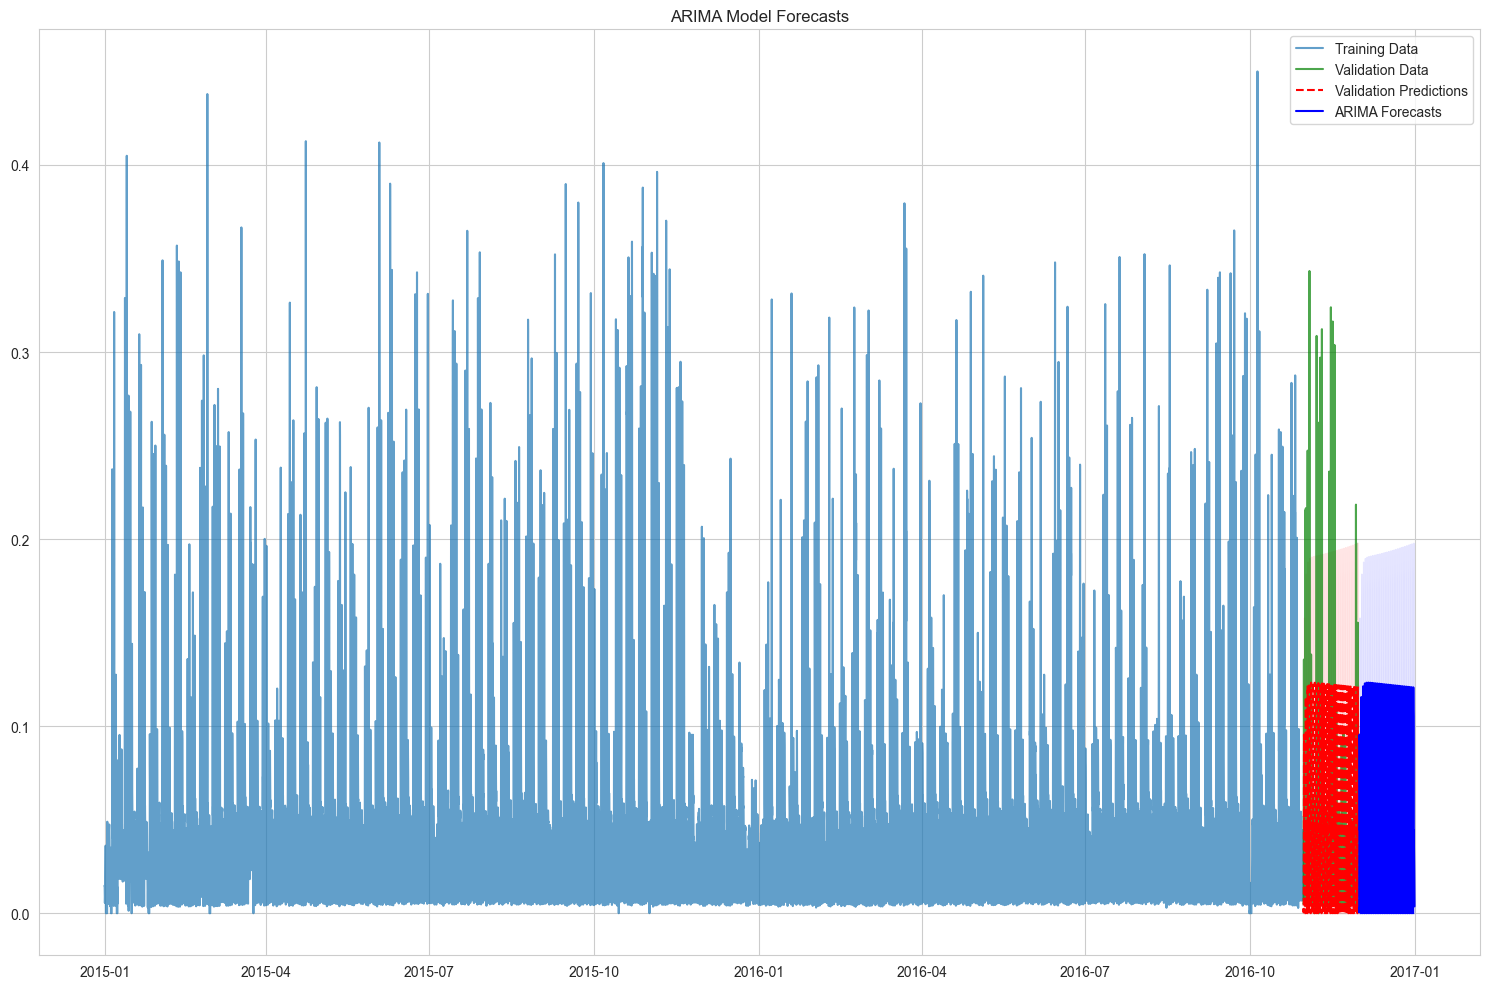


Validation Set Metrics:
RMSE: 0.0394
MAE: 0.0199
MAPE: inf%

ARIMA modeling pipeline completed!

Forecasts have been saved to 'arima_forecasts.csv'


In [16]:
# Cell 14 - Run ARIMA Pipeline
print("Starting ARIMA modeling pipeline...")

try:
    # First develop and train the model
    arima_model, best_order, best_seasonal_order = develop_arima_model(train_set)

    # Perform diagnostics
    perform_arima_diagnostics(arima_model)

    # Generate forecasts
    forecast_mean, forecast_conf, val_mean, val_conf = generate_arima_forecasts(arima_model, train_set, val_set)

    # Save forecasts to CSV
    forecast_df = pd.DataFrame({
        'datetime': pd.date_range(start=val_set.index[-1] + pd.Timedelta(hours=1),
                                periods=744,
                                freq='H'),
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.set_index('datetime', inplace=True)
    forecast_df.to_csv('arima_forecasts.csv')
    
    print("\nARIMA modeling pipeline completed!")
    print("\nForecasts have been saved to 'arima_forecasts.csv'")

except Exception as e:
    print(f"Error in ARIMA pipeline: {str(e)}")
    raise

Found existing forecasts, creating plot...


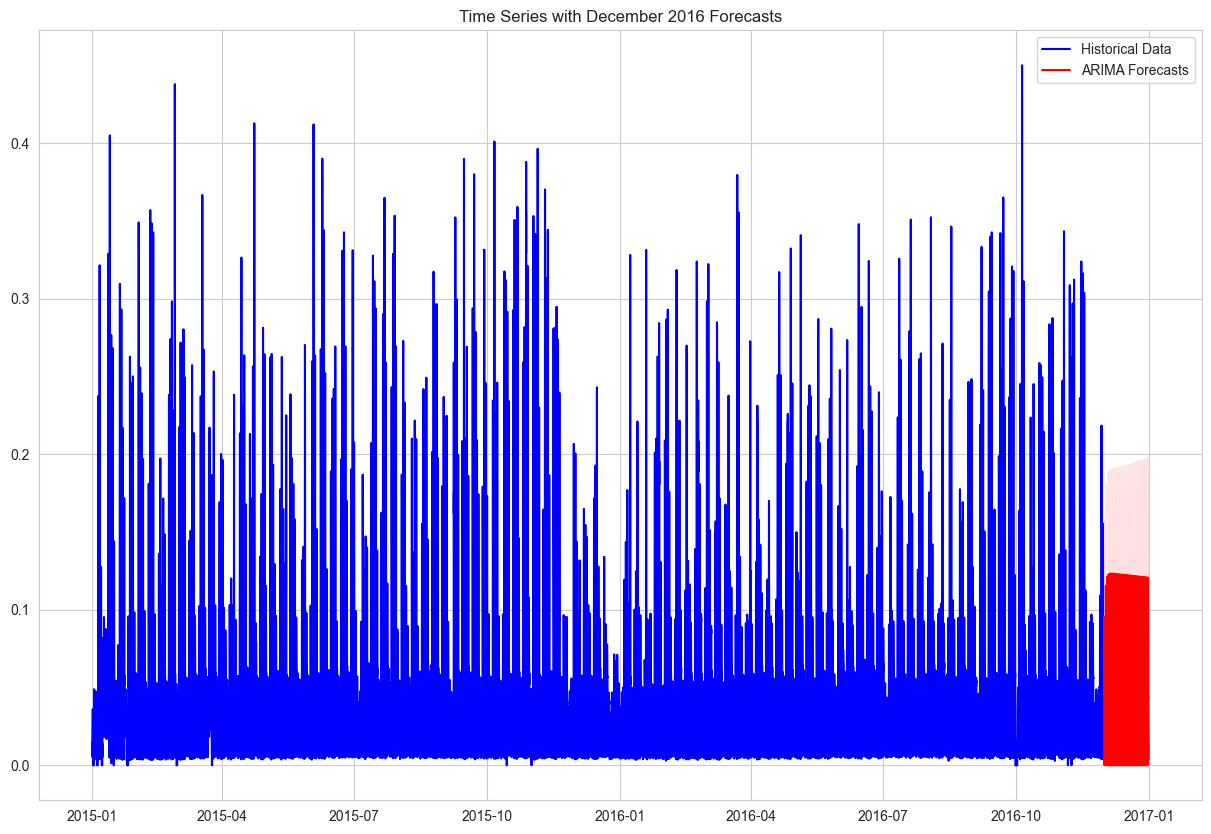

In [17]:
# Cell 15 - Create plot combining original data and forecasts

import os

def plot_with_forecasts(df, forecast_csv):
    """
    Plot original time series with forecasts appended
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Create plot
    plt.figure(figsize=(15, 10))
    
    # Plot original data until November 2016
    plt.plot(df.index, df['X'], label='Historical Data', color='blue')
    
    # Add forecasts as continuation
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'], 
             label='ARIMA Forecasts', color='red')
    
    # Add confidence intervals
    plt.fill_between(forecasts['datetime'],
                     forecasts['ARIMA_lower'],
                     forecasts['ARIMA_upper'],
                     color='red', alpha=0.1)
    
    plt.title('Time Series with December 2016 Forecasts')
    plt.legend()
    plt.grid(True)
    plt.show()

# First check if we have the forecasts CSV
if os.path.exists('arima_forecasts.csv'):
    print("Found existing forecasts, creating plot...")
    plot_with_forecasts(df, 'arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting forecasts...

Forecast Statistics:
Mean: 0.0382
Std Dev: 0.0336
Min: 0.0000
Max: 0.1233


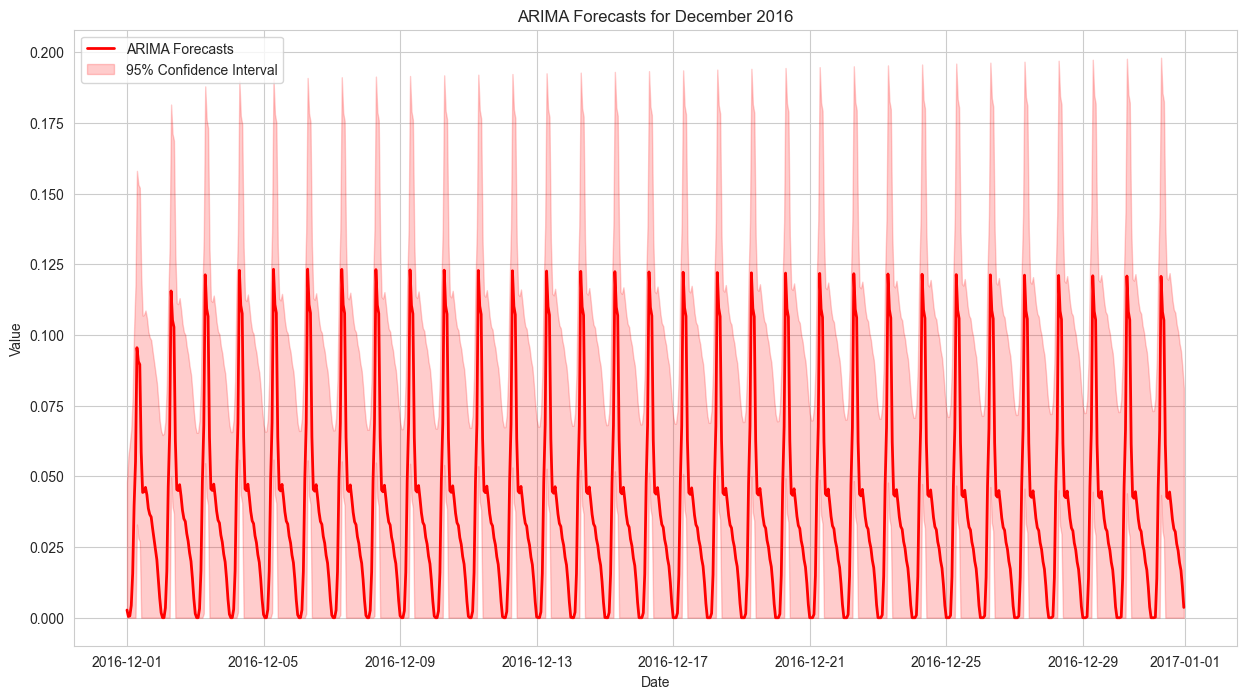

In [18]:
# Cell 16 - Plot just the forecasted values
def plot_forecasts_only(forecast_csv):
    """
    Plot only the forecasted values for December 2016
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot forecasts
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='ARIMA Forecasts', color='red', linewidth=2)
    
    # Add confidence intervals
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='red', alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('ARIMA Forecasts for December 2016')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print some statistics about the forecasts
    print("\nForecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    plt.show()

if os.path.exists('arima_forecasts.csv'):
    print("Plotting forecasts...")
    plot_forecasts_only('arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting November comparison...

November Statistics:
Mean: 0.0463
Std Dev: 0.0537
Min: 0.0000
Max: 0.3433

December Forecast Statistics:
Mean: 0.0382
Std Dev: 0.0336
Min: 0.0000
Max: 0.1233


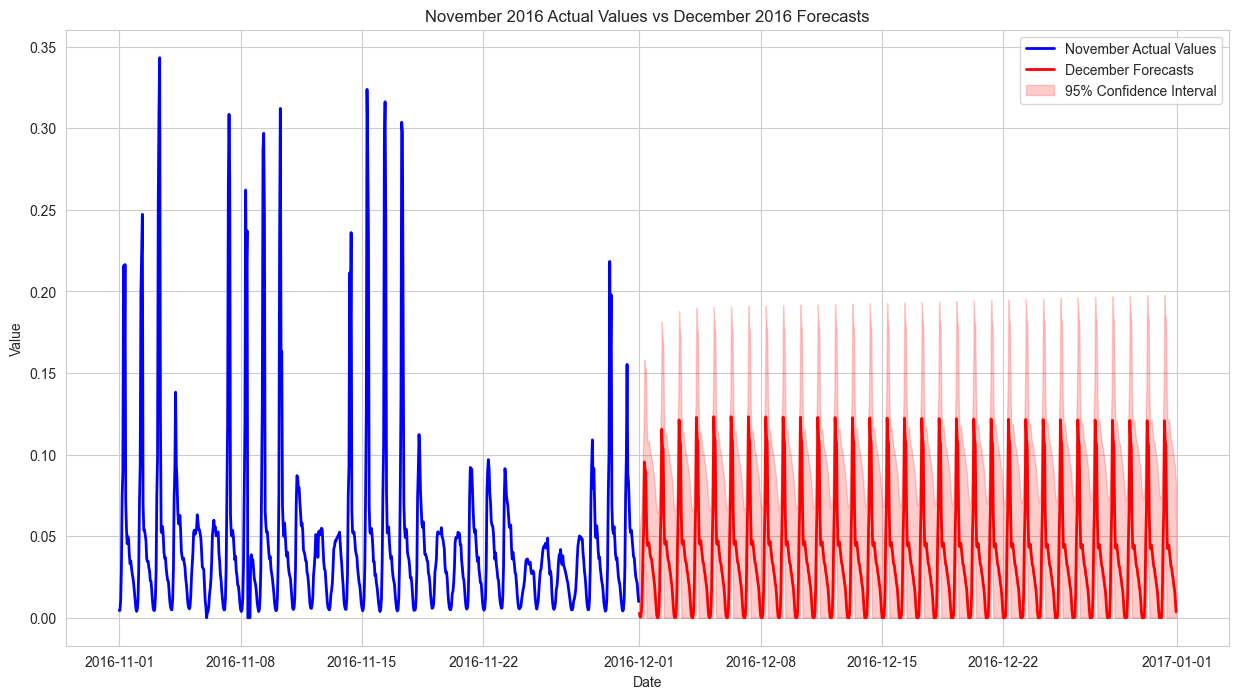

In [19]:
# Cell 17 - Plot November actuals and December forecasts
def plot_nov_dec_comparison(df, forecast_csv):
    """
    Plot November 2016 actual values and December 2016 forecasts
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Get November data (last month before forecasts)
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot November actual values
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values', color='blue', linewidth=2)
    
    # Plot December forecasts
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='December Forecasts', color='red', linewidth=2)
    
    # Add confidence intervals for forecasts
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='red', alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('November 2016 Actual Values vs December 2016 Forecasts')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print statistics for comparison
    print("\nNovember Statistics:")
    print(f"Mean: {november_data['X'].mean():.4f}")
    print(f"Std Dev: {november_data['X'].std():.4f}")
    print(f"Min: {november_data['X'].min():.4f}")
    print(f"Max: {november_data['X'].max():.4f}")
    
    print("\nDecember Forecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    plt.show()

if os.path.exists('arima_forecasts.csv'):
    print("Plotting November comparison...")
    plot_nov_dec_comparison(df, 'arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting complete comparison...

Forecast columns: ['datetime', 'ARIMA_forecast', 'ARIMA_lower', 'ARIMA_upper']

Solution columns: ['DateTime', 'Date', 'Hour', 'X']

November Statistics:
Mean: 0.0463
Std Dev: 0.0537
Min: 0.0000
Max: 0.3433

December Forecast Statistics:
Mean: 0.0382
Std Dev: 0.0336
Min: 0.0000
Max: 0.1233

December Real Values Statistics:
Mean: 0.0392
Std Dev: 0.0331
Min: 0.0000
Max: 0.2537

Forecast Error Metrics:
MAE: 0.0155
RMSE: 0.0263
MAPE: nan%


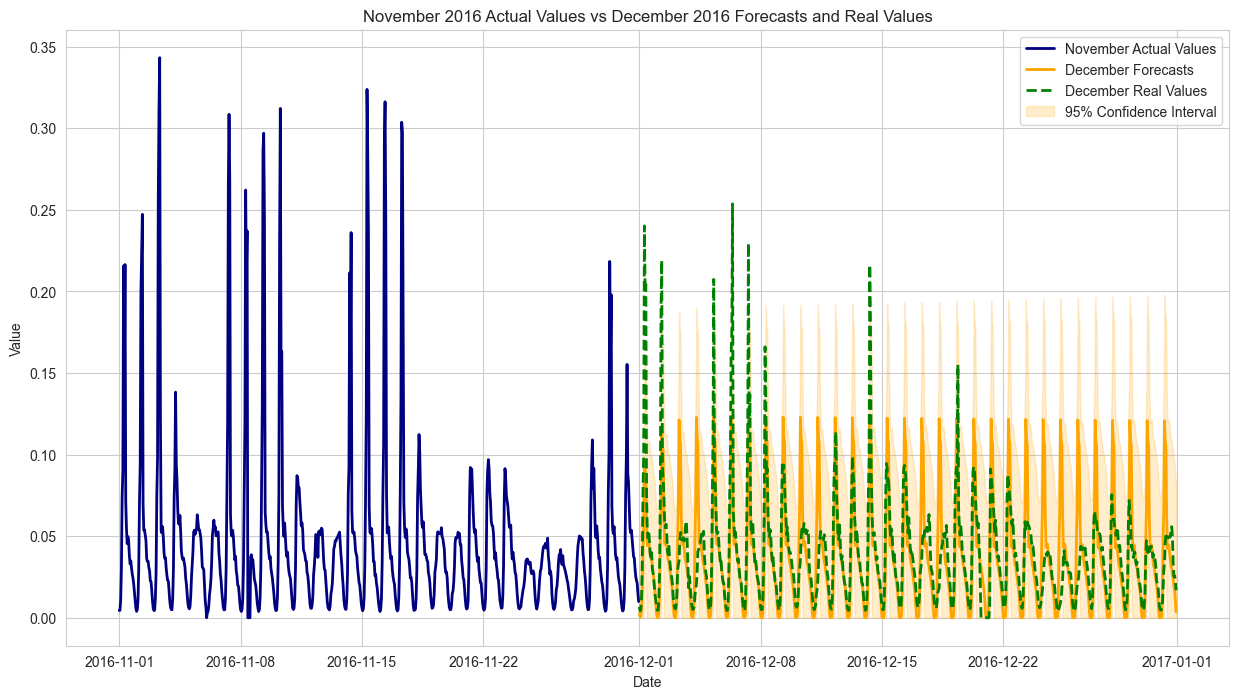

In [20]:
# Cell 18 - Plot November actuals, December forecasts, and December real values
def plot_complete_comparison(df, forecast_csv, solution_path):
    """
    Plot November 2016 actual values, December 2016 forecasts, and December 2016 real values
    Colors chosen for colorblind visibility:
    - November actuals: Dark Blue
    - December forecasts: Orange
    - December real values: Green
    - Confidence intervals: Light Orange shading
    """
    # Read the forecasts and solution with debug prints
    forecasts = pd.read_csv(forecast_csv)
    print("\nForecast columns:", forecasts.columns.tolist())
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Read and inspect solution file
    solution = pd.read_csv(solution_path)
    print("\nSolution columns:", solution.columns.tolist())
    
    # Create datetime index for solution based on December 2016
    solution.index = pd.date_range(start='2016-12-01', 
                                 periods=len(solution), 
                                 freq='H')
    
    # Get November data
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot November actual values (Dark Blue)
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values', 
             color='#000080',  # Dark Blue
             linewidth=2)
    
    # Plot December forecasts (Orange)
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='December Forecasts', 
             color='#FFA500',  # Orange
             linewidth=2)
    
    # Plot December real values (Green) - assuming 'X' is the column name in solution
    plt.plot(solution.index, solution['X'],
             label='December Real Values', 
             color='#008000',  # Green
             linewidth=2,
             linestyle='--')
    
    # Add confidence intervals for forecasts (Light Orange shading)
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',  # Orange
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('November 2016 Actual Values vs December 2016 Forecasts and Real Values')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print statistics for comparison
    print("\nNovember Statistics:")
    print(f"Mean: {november_data['X'].mean():.4f}")
    print(f"Std Dev: {november_data['X'].std():.4f}")
    print(f"Min: {november_data['X'].min():.4f}")
    print(f"Max: {november_data['X'].max():.4f}")
    
    print("\nDecember Forecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    print("\nDecember Real Values Statistics:")
    print(f"Mean: {solution['X'].mean():.4f}")
    print(f"Std Dev: {solution['X'].std():.4f}")
    print(f"Min: {solution['X'].min():.4f}")
    print(f"Max: {solution['X'].max():.4f}")
    
    # Calculate and print error metrics between forecasts and real values
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    mape = np.mean(np.abs((solution['X'] - forecasts['ARIMA_forecast']) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts.csv') and os.path.exists(solution_path):
    print("Plotting complete comparison...")
    plot_complete_comparison(df, 'arima_forecasts.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

## ARIMA Advanced - SARIMAX with Christmas

In [21]:
# Cell 19 - More Efficient Seasonal Features
def create_efficient_features(dates):
    """
    Create efficient features for both daily and weekly patterns
    """
    features = pd.DataFrame(index=dates)
    
    # Hour of day (0-23) as cyclical features
    hours = 24
    features['hour_sin'] = np.sin(2 * np.pi * dates.hour / hours)
    features['hour_cos'] = np.cos(2 * np.pi * dates.hour / hours)
    
    # Day of week (0-6) as cyclical features
    days = 7
    features['day_sin'] = np.sin(2 * np.pi * dates.dayofweek / days)
    features['day_cos'] = np.cos(2 * np.pi * dates.dayofweek / days)
    
    # Christmas evening indicator
    christmas_evenings = ((dates.day.isin([25, 26])) & 
                         (dates.hour.isin(range(20, 24))) |
                         (dates.day.isin([26, 27])) & 
                         (dates.hour.isin(range(0, 6))))
    features['christmas_evening'] = christmas_evenings.astype(int)
    
    return features

In [22]:
# Cell 20 - Efficient ARIMA Model
def develop_efficient_seasonal_arima(train_data):
    """
    Develop ARIMA model with daily seasonality and external regressors for weekly patterns
    """
    print("=== Efficient Seasonal ARIMA Model Development ===")

    # Prepare the target variable
    y = train_data['X'].astype(float)
    y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
    # Create efficient features
    exog_train = create_efficient_features(y.index)
    print(f"\nIncluded features: {exog_train.columns.tolist()}")
    
    try:
        # Fit model with daily seasonality and external regressors
        model = ARIMA(y,
                     order=(2, 1, 2),        # Regular ARIMA components
                     seasonal_order=(1, 1, 1, 24),  # Daily seasonality
                     exog=exog_train,        # Weekly patterns through cyclical features
                     enforce_stationarity=False,
                     enforce_invertibility=True)
        
        results = model.fit()
        print("\nModel Summary:")
        print(results.summary())
        
        return results
        
    except Exception as e:
        print(f"Error fitting model:")
        print(f"Error message: {str(e)}")
        raise

In [23]:
# Cell 21 - Efficient Forecast Generation
def generate_efficient_forecasts(model, train_data, forecast_horizon=744):
    """
    Generate forecasts efficiently
    """
    # Create forecast dates
    forecast_start = train_data.index[-1] + pd.Timedelta(hours=1)
    forecast_dates = pd.date_range(forecast_start, periods=forecast_horizon, freq='H')
    
    # Create features for forecast period
    exog_forecast = create_efficient_features(forecast_dates)
    
    # Generate forecasts
    forecasts = model.forecast(steps=forecast_horizon, exog=exog_forecast)
    forecasts = np.maximum(forecasts, 0)  # Ensure non-negative
    
    # Get confidence intervals
    conf_int = model.get_forecast(steps=forecast_horizon, exog=exog_forecast).conf_int()
    conf_int.iloc[:, 0] = np.maximum(conf_int.iloc[:, 0], 0)  # Ensure non-negative lower bound
    
    return forecasts, conf_int, forecast_dates

In [24]:
# Cell 22 - Run Efficient Pipeline
print("Starting Efficient ARIMA modeling pipeline...")

try:
    # Train the model
    arima_model = develop_efficient_seasonal_arima(train_set)
    
    # Generate forecasts
    forecast_mean, forecast_conf, forecast_dates = generate_efficient_forecasts(arima_model, train_set)
    
    # Create and save forecast DataFrame
    forecast_df = pd.DataFrame({
        'datetime': forecast_dates,
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.to_csv('arima_forecasts_efficient.csv', index=False)
    
    print("\nEfficient ARIMA model completed!")
    print("Forecasts saved to 'arima_forecasts_efficient.csv'")

except Exception as e:
    print(f"Error in pipeline: {str(e)}")
    raise

Starting Efficient ARIMA modeling pipeline...
=== Efficient Seasonal ARIMA Model Development ===

Included features: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'christmas_evening']


c:\Users\alexc\GitHubRepos\Project_TimeSeries\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37345.423
Date:                            Fri, 10 Jan 2025   AIC                         -74666.846
Time:                                    09:48:08   BIC                         -74574.679
Sample:                                01-01-2015   HQIC                        -74636.363
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
hour_sin          -3.362e-09   6.73e-08     -0.050      0.960   -1.35e-07    1.29e-0

Plotting complete comparison...

Forecast Error Metrics:
MAE: 0.0167
RMSE: 0.0281


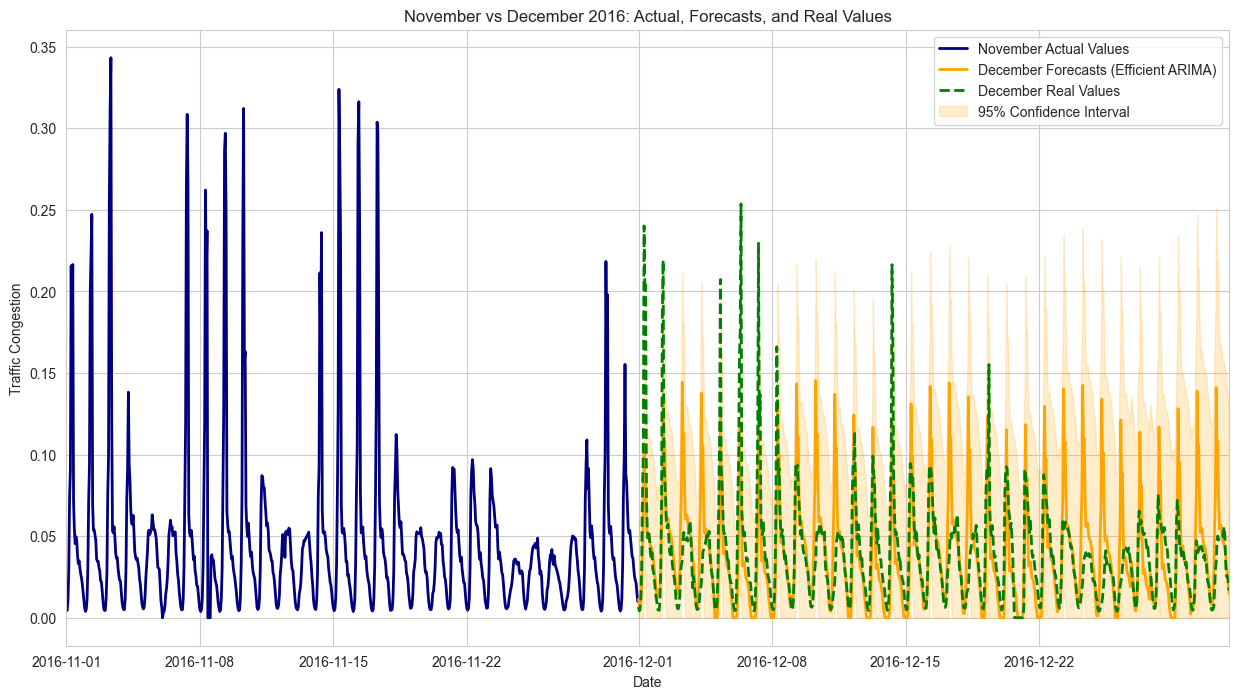

In [25]:
# Cell 23 - Plot Efficient Model Results
def plot_complete_comparison_efficient(df, forecast_csv, solution_path):
    """
    Plot November actuals, December efficient forecasts, and December real values
    Colors chosen for colorblind visibility:
    - November actuals: Dark Blue
    - December forecasts: Orange
    - December real values: Green
    - Confidence intervals: Light Orange shading
    """
    # Read data files
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01', 
                                 periods=len(solution), 
                                 freq='H')
    
    # Get November data
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create plot with proper size and dpi for better readability
    plt.figure(figsize=(15, 8), dpi=100)
    
    # Plot November actual values (Dark Blue)
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values', 
             color='#000080',  # Dark Blue
             linewidth=2)
    
    # Plot December forecasts (Orange) - making sure it's in December
    plt.plot(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
             forecasts['ARIMA_forecast'],
             label='December Forecasts (Efficient ARIMA)', 
             color='#FFA500',  # Orange
             linewidth=2)
    
    # Plot December real values (Green)
    plt.plot(solution.index, solution['X'],
             label='December Real Values', 
             color='#008000',  # Green
             linewidth=2,
             linestyle='--')
    
    # Add confidence intervals - making sure they're in December
    plt.fill_between(pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H'),
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',  # Orange
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('November vs December 2016: Actual, Forecasts, and Real Values')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Adjust x-axis to show the entire period clearly
    plt.xlim(november_data.index[0], solution.index[-1])
    
    # Print comparison statistics
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts_efficient.csv') and os.path.exists(solution_path):
    print("Plotting complete comparison...")
    plot_complete_comparison_efficient(df, 'arima_forecasts_efficient.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

Plotting separate comparisons...

Forecast Error Metrics:
MAE: 0.0167
RMSE: 0.0281


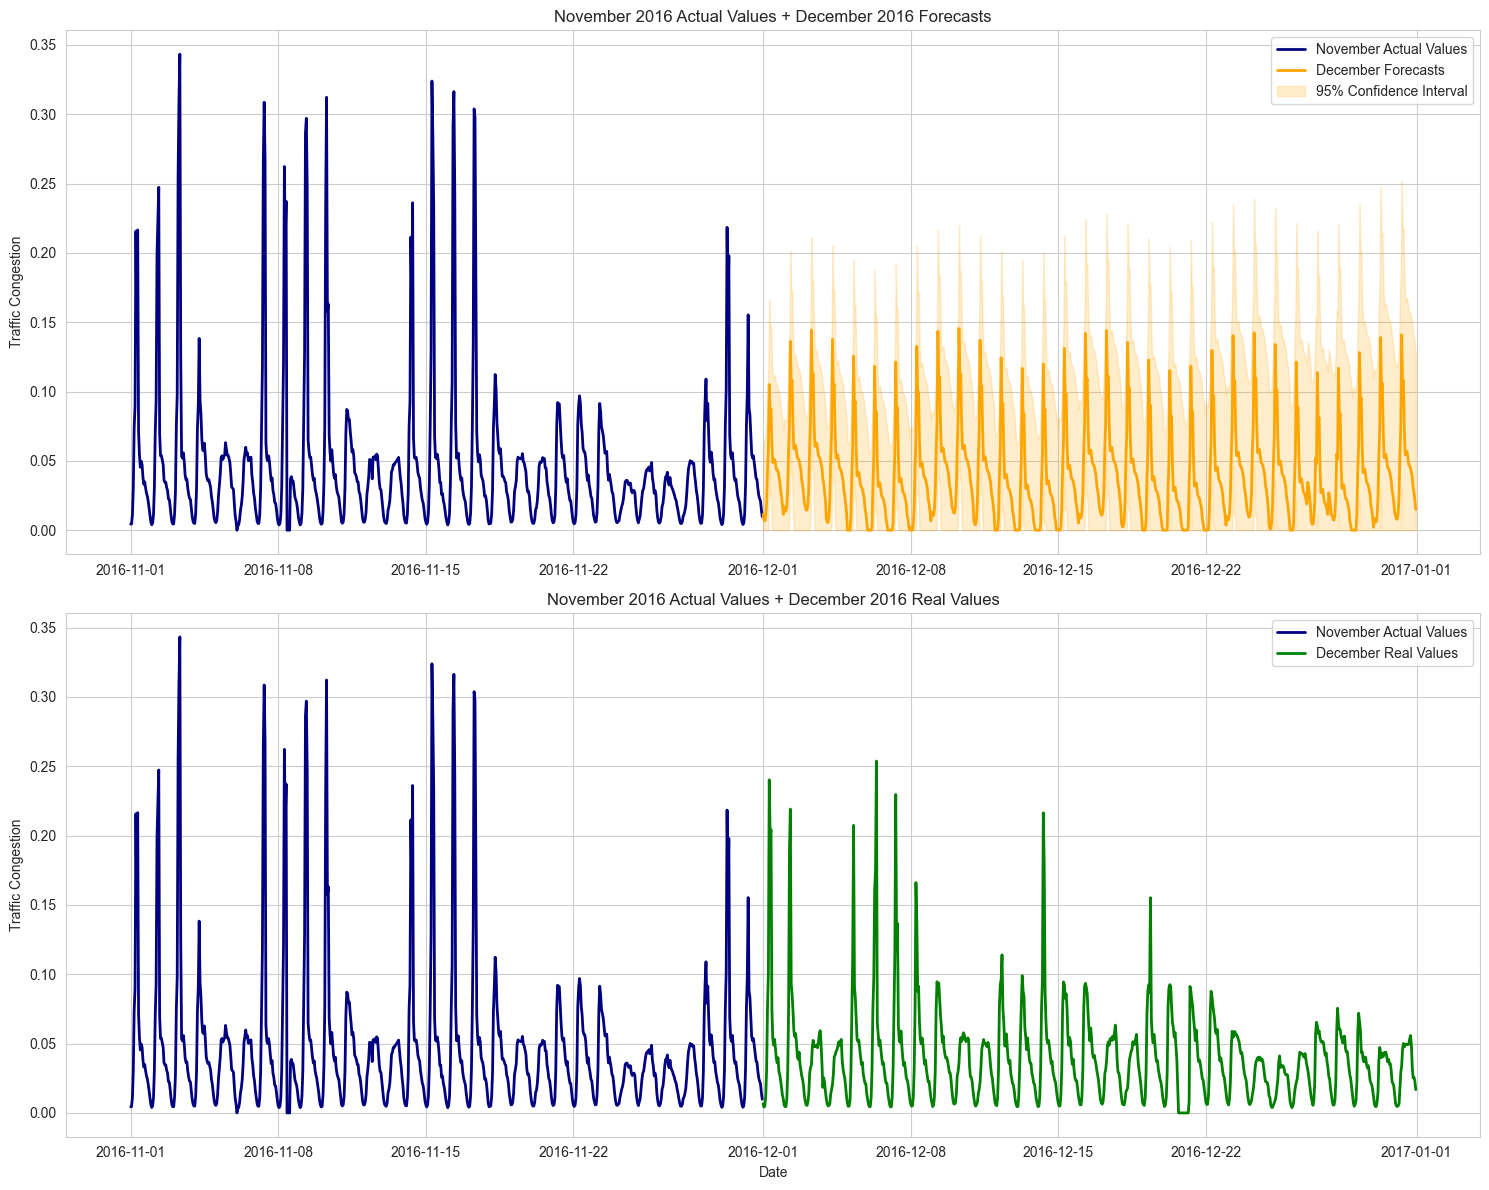

In [26]:
# Cell 24 - Create separate plots for forecasts and real values
def plot_separate_comparisons(df, forecast_csv, solution_path):
    """
    Create two separate plots:
    1. November actuals + December forecasts
    2. November actuals + December real values
    
    Colors chosen for colorblind visibility:
    - November actuals: Dark Blue
    - December forecasts: Orange
    - December real values: Green
    - Confidence intervals: Light Orange shading
    """
    # Read data files
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01', 
                                 periods=len(solution), 
                                 freq='H')
    
    # Get November data
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), dpi=100)
    
    # Plot 1: November + December Forecasts
    ax1.plot(november_data.index, november_data['X'],
            label='November Actual Values', 
            color='#000080',  # Dark Blue
            linewidth=2)
    
    december_dates = pd.date_range(start='2016-12-01', periods=len(forecasts), freq='H')
    ax1.plot(december_dates, forecasts['ARIMA_forecast'],
            label='December Forecasts', 
            color='#FFA500',  # Orange
            linewidth=2)
    
    ax1.fill_between(december_dates,
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',  # Orange
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    ax1.set_title('November 2016 Actual Values + December 2016 Forecasts')
    ax1.set_ylabel('Traffic Congestion')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: November + December Real Values
    ax2.plot(november_data.index, november_data['X'],
            label='November Actual Values', 
            color='#000080',  # Dark Blue
            linewidth=2)
    
    ax2.plot(solution.index, solution['X'],
            label='December Real Values', 
            color='#008000',  # Green
            linewidth=2)
    
    ax2.set_title('November 2016 Actual Values + December 2016 Real Values')
    ax2.set_ylabel('Traffic Congestion')
    ax2.set_xlabel('Date')
    ax2.grid(True)
    ax2.legend()
    
    # Adjust layout and display
    plt.tight_layout()
    
    # Print comparison statistics
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts_efficient.csv') and os.path.exists(solution_path):
    print("Plotting separate comparisons...")
    plot_separate_comparisons(df, 'arima_forecasts_efficient.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

# Analysis of SARIMA Models for Hourly Traffic Data

## 1. Model Structures and Intuition

### Model 1: SARIMA(2, 1, 2)(1, 1, 1)_24

- **Regular ARIMA part:** \((p,d,q) = (2,1,2)\)  
  - 2 autoregressive terms (\(\text{AR}(2)\))  
  - 1 regular difference (\(d = 1\))  
  - 2 moving average terms (\(\text{MA}(2)\))  
- **Seasonal part (period = 24 hours):** \((P,D,Q) = (1,1,1)\)  
  - 1 seasonal AR(\(\Phi_1\)) term  
  - 1 seasonal difference (\(D = 1\))  
  - 1 seasonal MA(\(\Theta_1\)) term  

This implies the data has a strong daily seasonal structure and also some short-term hour-to-hour correlations.

The model is:

\[
\phi_2(B)\,\Phi_1(B^{24})\,(1-B)\,(1-B^{24})\,X_t 
\;=\; \theta_2(B)\,\Theta_1(B^{24})\,\varepsilon_t.
\]

---

### Model 2: SARIMAX(2, 1, 2)(1, 1, 1)_24 with External Regressors

- **Same SARIMA structure** as Model 1, **plus** external regressors \(\beta' Z_t\):  
  - \(Z_t\) includes: \(\text{hour_sin}, \text{hour_cos}, \text{day_sin}, \text{day_cos}, \text{christmas_evening}\).  

The equation (simplified) is:

\[
\phi_2(B)\,\Phi_1(B^{24})\,(1-B)\,(1-B^{24})\,[\,X_t - \beta' Z_t\,]
\;=\; \theta_2(B)\,\Theta_1(B^{24})\,\varepsilon_t.
\]

The goal is to see if adding specific cyclical and holiday effects improves the model fit and forecasts.

---

## 2. Comparing Key Fit Statistics

| Model            | Log-Likelihood | AIC         | BIC         |
|------------------|----------------|-------------|-------------|
| **Model 1**      | 37587.551      | -75161.101  | -75107.337  |
| **Model 2**      | 37345.423      | -74666.846  | -74574.679  |

- **Model 1** has a higher log-likelihood (37587 vs. 37345).  
- **Model 1** also has lower (better) AIC and BIC than Model 2.

By standard information criteria, **Model 1** outperforms **Model 2**, even though Model 2 includes additional regressors.

---

## 3. Parameter Estimates and Significance

### 3.1. Model 1 Parameter Estimates

- **ar.L1:** 1.0280 (p < 0.0001)  
- **ar.L2:** -0.2997 (p < 0.0001)  
- **ma.L1:** -1.2680 (p < 0.0001)  
- **ma.L2:** 0.2727 (p < 0.0001)  
- **ar.S.L24:** 0.2885 (p < 0.0001)  
- **ma.S.L24:** -0.9842 (p < 0.0001)  
- **\(\sigma^2\):** 0.0005  

**Implications:**

1. **Nonseasonal AR(1) is slightly above 1**: Could indicate a high level of persistence, but combined with differencing and other terms, it may still be stationary in practice.  
2. **Nonseasonal AR(2) is negative**: Suggests hour-to-hour dynamics might reverse after 2 lags.  
3. **Large negative MA(1)**: Implies strong “shock” corrections from one hour to the next.  
4. **Seasonal terms** show a strong daily pattern (24-hour). The large negative seasonal MA suggests strong correction day-to-day at the same hour.  
5. **Very small \(\sigma^2\)** on the differenced scale indicates a tight fit.

---

### 3.2. Model 2 Parameter Estimates

- **External Regressors**:  
  - **hour_sin:** ~\(-3.36 \times 10^{-9}\), p=0.96 (not significant)  
  - **hour_cos:** ~\(1.03 \times 10^{-9}\), p=0.98 (not significant)  
  - **day_sin:** 0.0144, p<0.0001 (significant)  
  - **day_cos:** 0.0007, p=0.49 (not significant)  
  - **christmas_evening:** 0.0236, p<0.0001 (significant)  

- **ARMA terms**:  
  - **ar.L1:** 0.0284 (p=0.82, not significant)  
  - **ar.L2:** 0.3529 (p<0.0001, significant)  
  - **ma.L1:** -0.3691 (p=0.003, significant)  
  - **ma.L2:** -0.6173 (p<0.0001, significant)  
  - **ar.S.L24:** 0.2995 (p<0.0001, significant)  
  - **ma.S.L24:** -0.9420 (p<0.0001, significant)  

- **\(\sigma^2\):** 0.0006  

**Implications:**

1. **hour_sin/cos are effectively zero** and not significant, suggesting the 24-hour seasonal ARIMA structure itself captures the diurnal pattern.  
2. **day_sin is significant**, indicating a weekly cycle not fully captured by the 24-hour differencing.  
3. **day_cos is not significant**. Possibly day_sin alone is enough, or there’s collinearity.  
4. **christmas_evening is significant**, indicating a unique effect around Christmas.  
5. **AR(1) is no longer significant** once external regressors are added.  
6. The overall \(\sigma^2\) is slightly larger than in Model 1, and AIC/BIC are worse.

---

## 4. Residual Diagnostics

- **Ljung-Box (L1) (Q):**  
  - Model 1: 1.22 (p=0.27)  
  - Model 2: 105.71 (p=0.00)  

  Model 2’s residuals show significant autocorrelation at lag 1, whereas Model 1’s residuals do not.

- **Jarque-Bera (JB):** Extremely large for both, indicating **non-normality** in residuals. This is common in traffic data.  
- **Heteroskedasticity (H) tests:** Both show p-values suggesting some non-constant variance in residuals (again, common in traffic contexts).

---

## 5. Overall Implications & Next Steps

1. **Model 1 (Pure SARIMA) Outperforms Model 2 (SARIMAX)**  
   - Lower AIC/BIC and higher log-likelihood indicate a better fit.  
   - The added regressors (especially hour_sin, hour_cos) don’t help much beyond what the 24-hour seasonal differencing already provides.

2. **Significant Regressors** in Model 2 (day_sin, christmas_evening) do show real effects, but the overall fit doesn’t improve enough to beat Model 1 in penalized-likelihood terms.

3. **Potential Over-Differencing / High Persistence**  
   - AR(1) near or above 1 can happen; ensure stationarity conditions hold by checking inverse roots.

4. **Residual Diagnostics**  
   - Both models deviate from normality and may have heteroskedasticity. For best forecast intervals, consider alternative error structures or transformations.

5. **Choosing the “Best” Model**  
   - If you want the best numeric fit and forecasts, **Model 1** appears superior.  
   - If interpretability about weekly or holiday effects is crucial, you could still consider a SARIMAX approach (perhaps removing hour_sin/hour_cos and optimizing further).

6. **Next Steps**  
   - Try a model that keeps “day_sin” and “christmas_evening” but omits the unhelpful hour_sin/hour_cos terms.  
   - Consider multi-seasonal approaches (e.g., 24-hour + 168-hour for weekly seasonality), or day-of-week dummies.  
   - Consider variance-stabilizing transformations if the raw residuals show heavy skew/kurtosis.

---

## 6. Summary

- **Model 1**: By AIC/BIC, this is the better-fitting model for hourly traffic. It captures strong daily seasonality and short-term AR/MA components.  
- **Model 2**: Although it includes meaningful regressors (especially day-of-week and holiday effects), it does not outperform Model 1 in overall fit. The 24-hour seasonal differencing/ARMA already explains much of the diurnal pattern, leaving the cyclical hour regressors insignificant.  
- **Residuals**: Both models have non-normal, possibly heteroskedastic residuals, which is not unusual in traffic data.  

In practice, **Model 1** might be the simpler, better choice for forecasting hourly traffic, while **Model 2** has added interpretability regarding holiday and weekly patterns but does not necessarily improve forecast accuracy.


# UCM

In [27]:
# Cell 25 - UCM Base Imports and Setup
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.structural import UnobservedComponents
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Cell 26 - UCM Data Preparation Function
def prepare_ucm_data(df: pd.DataFrame, 
                    forecast_horizon: int = 744) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Prepare data for UCM modeling, including feature engineering
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame with DateTime index and 'X' column
    forecast_horizon : int
        Number of periods to forecast (default 744 for one month of hourly data)
        
    Returns:
    --------
    train_data : pd.DataFrame
        Training data with engineered features
    val_data : pd.DataFrame
        Validation data
    """
    # Make a copy to avoid modifying original data
    data = df.copy()
    
    # Add time-based features
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    data['month'] = data.index.month
    
    # Create cyclical features
    data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24)
    data['day_sin'] = np.sin(2 * np.pi * data['day_of_week']/7)
    data['day_cos'] = np.cos(2 * np.pi * data['day_of_week']/7)
    
    # Christmas evening indicator (Dec 24-26)
    christmas_evenings = ((data.index.month == 12) & 
                         (data.index.day.isin([24, 25, 26])) &
                         (data.index.hour.isin(range(18, 24))))
    data['christmas_evening'] = christmas_evenings.astype(int)
    
    # Split into training and validation
    train_data = data[data['X'].notna()].copy()
    val_data = train_data[-forecast_horizon:].copy()
    train_data = train_data[:-forecast_horizon].copy()
    
    return train_data, val_data

# Test the function
train_data, val_data = prepare_ucm_data(df)
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("\nFeatures created:", train_data.columns.tolist())

Training data shape: (16056, 11)
Validation data shape: (744, 11)

Features created: ['Date', 'Hour', 'X', 'hour', 'day_of_week', 'month', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'christmas_evening']


In [44]:
# Cell 27 (Updated with Verification) - UCM Model Fitting Function
def fit_ucm_model(train_data: pd.DataFrame,
                 model_type: str = 'basic') -> UnobservedComponents:
    """
    Fit UCM model with specified configuration
    """
    y = train_data['X']
    
    if model_type == 'seasonal' or model_type == 'full':
        # Model with both seasonalities
        seasonal_spec = [
            {'period': 24, 'harmonics': 12},      # Daily seasonality
            {'period': 168, 'harmonics': 84}      # Weekly seasonality (increased harmonics)
        ]
        
        # Print verification of seasonal components
        print("\nVerifying seasonal specifications:")
        print(f"Daily seasonality: period=24, harmonics=12")
        print(f"Weekly seasonality: period=168, harmonics=84")
        
        if model_type == 'full':
            exog = train_data[['hour_sin', 'hour_cos', 
                             'day_sin', 'day_cos',
                             'christmas_evening']]
            
            model = UnobservedComponents(
                y,
                exog=exog,
                level='local linear trend',
                freq_seasonal=seasonal_spec
            )
        else:
            model = UnobservedComponents(
                y,
                level='local linear trend',
                freq_seasonal=seasonal_spec
            )
        
        # Fit the model
        fitted_model = model.fit(disp=False)
        
        # Verify the fitted components
        print("\nFitted model components:")
        print(fitted_model.specification)
        print("\nModel parameters:")
        print(fitted_model.params)
        
        return fitted_model
    else:
        # Basic model (unchanged)
        model = UnobservedComponents(
            y,
            level='local linear trend',
            seasonal=None
        )
        return model.fit(disp=False)

In [45]:
# Cell 28 - UCM Forecasting Function
def generate_ucm_forecasts(model_fit: UnobservedComponents,
                         train_data: pd.DataFrame,
                         forecast_horizon: int = 744,
                         include_exog: bool = True) -> Tuple[np.ndarray, pd.DataFrame]:
    """
    Generate forecasts from fitted UCM model
    """
    if include_exog and hasattr(model_fit, 'exog') and model_fit.exog is not None:
        # Get future dates
        last_date = train_data.index[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1),
                                   periods=forecast_horizon,
                                   freq='H')
        
        # Create future exogenous features
        future_df = pd.DataFrame(index=future_dates)
        future_df['hour'] = future_df.index.hour
        future_df['day_of_week'] = future_df.index.dayofweek
        future_df['hour_sin'] = np.sin(2 * np.pi * future_df.index.hour/24)
        future_df['hour_cos'] = np.cos(2 * np.pi * future_df.index.hour/24)
        future_df['day_sin'] = np.sin(2 * np.pi * future_df.index.dayofweek/7)
        future_df['day_cos'] = np.cos(2 * np.pi * future_df.index.dayofweek/7)
        
        # Christmas evening indicator for future dates
        christmas_evenings = ((future_df.index.month == 12) & 
                            (future_df.index.day.isin([24, 25, 26])) &
                            (future_df.index.hour.isin(range(18, 24))))
        future_df['christmas_evening'] = christmas_evenings.astype(int)
        
        future_exog = future_df[['hour_sin', 'hour_cos', 
                                'day_sin', 'day_cos',
                                'christmas_evening']]
        
        # Generate forecasts with exogenous features
        forecasts = model_fit.forecast(steps=forecast_horizon, exog=future_exog)
        forecast_conf = model_fit.get_forecast(steps=forecast_horizon, 
                                             exog=future_exog).conf_int()
    else:
        # Generate forecasts without exogenous features
        forecasts = model_fit.forecast(steps=forecast_horizon)
        forecast_conf = model_fit.get_forecast(steps=forecast_horizon).conf_int()
    
    # Ensure non-negative values
    forecasts = np.maximum(forecasts, 0)
    forecast_conf = np.maximum(forecast_conf, 0)
    
    return forecasts, forecast_conf

In [46]:
# Cell 29 (Updated) - UCM Visualization and Evaluation Functions
def plot_ucm_components(model_fit: UnobservedComponents,
                       train_data: pd.DataFrame):
    """
    Plot decomposition of UCM components
    """
    # Get filtered states
    filtered_states = model_fit.filtered_state
    
    # Define component names based on model specification
    component_names = ['Level', 'Trend']
    
    # Create plot
    n_components = len(component_names)
    fig, axes = plt.subplots(n_components, 1, figsize=(15, 4*n_components))
    
    if n_components == 1:
        axes = [axes]
    
    # Plot each component
    for i, (component, name) in enumerate(zip(filtered_states, component_names)):
        axes[i].plot(train_data.index, component)
        axes[i].set_title(f'Estimated {name}')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_ucm_model(model_fit: UnobservedComponents,
                      val_data: pd.DataFrame,
                      forecasts: np.ndarray) -> Dict[str, float]:
    """
    Evaluate UCM model performance
    """
    actual = val_data['X'].values
    
    # Calculate metrics, handling potential division by zero in MAPE
    mae = mean_absolute_error(actual, forecasts)
    rmse = np.sqrt(mean_squared_error(actual, forecasts))
    
    # Calculate MAPE with handling for zero values
    non_zero_mask = actual != 0
    if np.any(non_zero_mask):
        mape = np.mean(np.abs((actual[non_zero_mask] - forecasts[non_zero_mask]) / 
                              actual[non_zero_mask])) * 100
    else:
        mape = np.nan
    
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }
    
    return metrics

Training basic UCM model (local linear trend only)...

Model Summary:
                        Unobserved Components Results                         
Dep. Variable:                      X   No. Observations:                16056
Model:             local linear trend   Log Likelihood               32894.416
Date:                Fri, 10 Jan 2025   AIC                         -65782.832
Time:                        10:35:09   BIC                         -65759.781
Sample:                    01-01-2015   HQIC                        -65775.210
                         - 10-30-2016                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.011e-08   3.29e-06      0.003      0.998   -6.44e-06    6.46e-06
sigma2.level         0.0010    7.4e-06    1

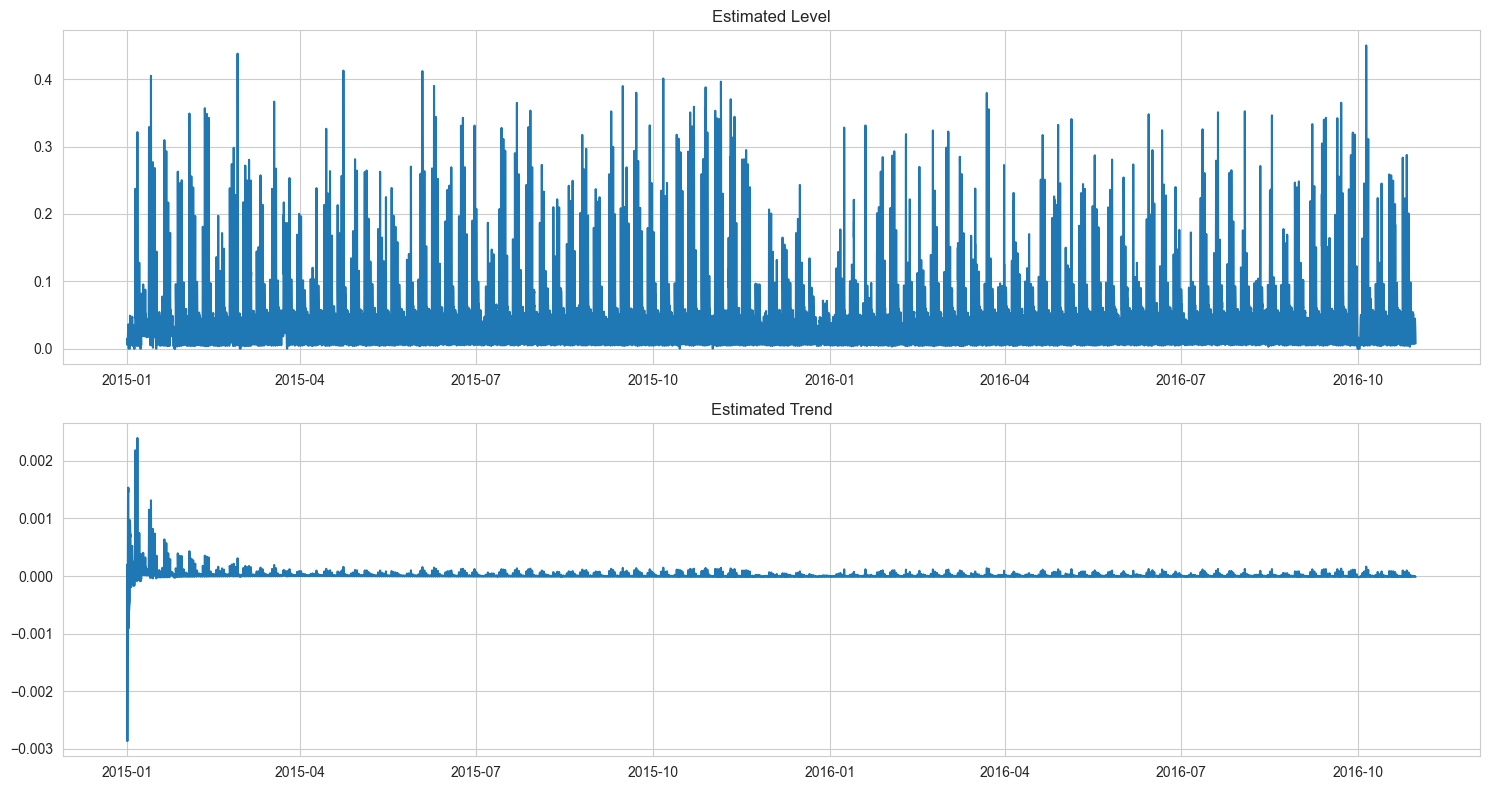

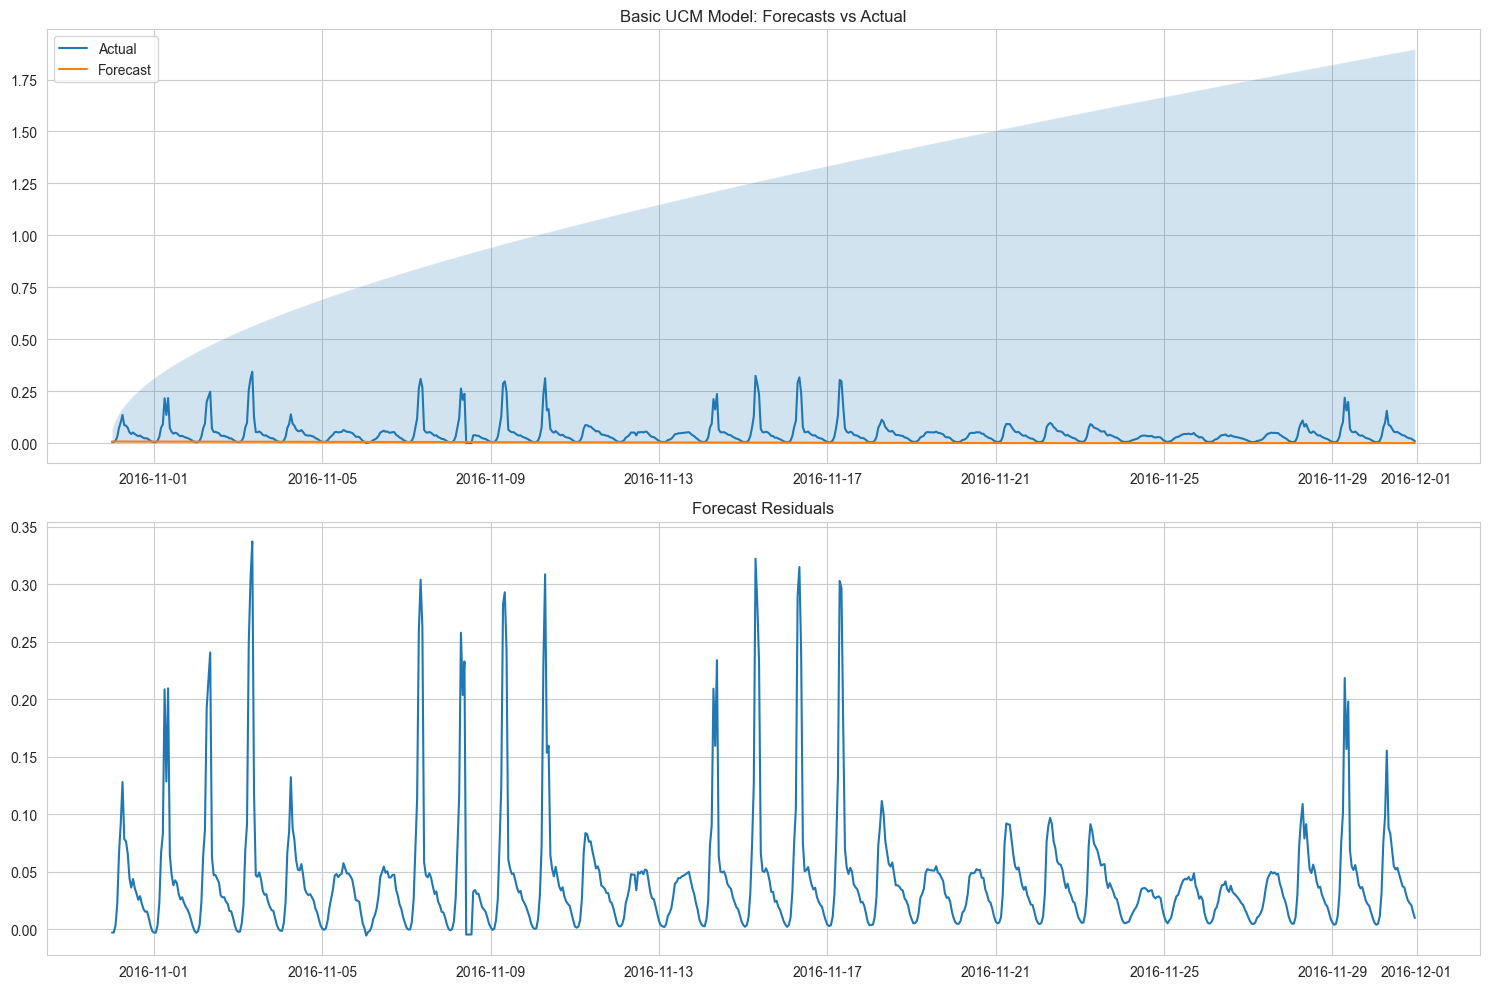

In [47]:
# Cell 30 (Updated) - Basic UCM Model Training and Evaluation
print("Training basic UCM model (local linear trend only)...")
basic_model = fit_ucm_model(train_data, model_type='basic')

print("\nModel Summary:")
print(basic_model.summary())

# Generate forecasts
basic_forecasts, basic_conf = generate_ucm_forecasts(
    basic_model, 
    train_data, 
    include_exog=False
)

# Evaluate on validation set
basic_metrics = evaluate_ucm_model(basic_model, val_data, basic_forecasts)
print("\nValidation Metrics:")
for metric, value in basic_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot components
print("\nPlotting model components:")
plot_ucm_components(basic_model, train_data)

# Additional diagnostic plots
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(val_data.index, val_data['X'], label='Actual')
plt.plot(val_data.index, basic_forecasts, label='Forecast')
plt.fill_between(val_data.index, 
                 basic_conf.iloc[:, 0], 
                 basic_conf.iloc[:, 1], 
                 alpha=0.2)
plt.title('Basic UCM Model: Forecasts vs Actual')
plt.legend()
plt.grid(True)

plt.subplot(212)
residuals = val_data['X'].values - basic_forecasts
plt.plot(val_data.index, residuals)
plt.title('Forecast Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# Cell 31 - Seasonal UCM Model Training and Evaluation
print("Training seasonal UCM model (trend + daily seasonality)...")
seasonal_model = fit_ucm_model(train_data, model_type='seasonal', seasonal_periods=24)

print("\nModel Summary:")
print(seasonal_model.summary())

# Generate forecasts
seasonal_forecasts, seasonal_conf = generate_ucm_forecasts(
    seasonal_model, 
    train_data, 
    include_exog=False
)

# Evaluate on validation set
seasonal_metrics = evaluate_ucm_model(seasonal_model, val_data, seasonal_forecasts)
print("\nValidation Metrics:")
for metric, value in seasonal_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot components
print("\nPlotting model components:")
plot_ucm_components(seasonal_model, train_data)

Training seasonal UCM model (trend + daily seasonality)...


TypeError: fit_ucm_model() got an unexpected keyword argument 'seasonal_periods'

Training full UCM model with multiple seasonalities...
Fitting full UCM model...

Model Summary:
                                 Unobserved Components Results                                 
Dep. Variable:                                       X   No. Observations:                16056
Model:                              local linear trend   Log Likelihood               36581.128
                    + stochastic freq_seasonal(24(12))   AIC                         -73142.255
                   + stochastic freq_seasonal(168(24))   BIC                         -73065.463
Date:                                 Fri, 10 Jan 2025   HQIC                        -73116.856
Time:                                         10:26:36                                         
Sample:                                     01-01-2015                                         
                                          - 10-30-2016                                         
Covariance Type:                       

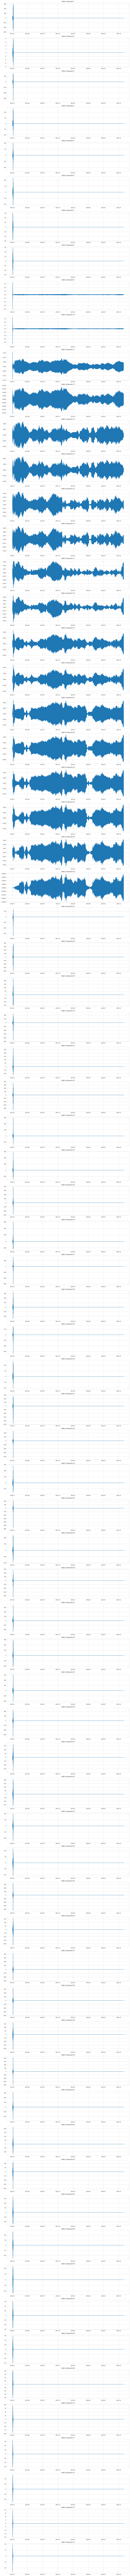

In [42]:
# Cell 32 (Updated) - Full UCM Model Training and Evaluation with Multiple Seasonalities
print("Training full UCM model with multiple seasonalities...")

# Fit the model
full_model = fit_ucm_model(train_data, model_type='full')

print("\nModel Summary:")
print(full_model.summary())

# Create future exogenous features for forecasting
last_date = train_data.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(hours=1),
    periods=744,  # One month forecast
    freq='H'
)

# Prepare future exogenous features
future_df = pd.DataFrame(index=future_dates)
future_df['hour'] = future_df.index.hour
future_df['day_of_week'] = future_df.index.dayofweek

# Create cyclical features
future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour']/24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour']/24)
future_df['day_sin'] = np.sin(2 * np.pi * future_df['day_of_week']/7)
future_df['day_cos'] = np.cos(2 * np.pi * future_df['day_of_week']/7)

# Christmas evening indicator
christmas_evenings = ((future_df.index.month == 12) & 
                     (future_df.index.day.isin([24, 25, 26])) &
                     (future_df.index.hour.isin(range(18, 24))))
future_df['christmas_evening'] = christmas_evenings.astype(int)

# Select features in the same order as training
future_exog = future_df[['hour_sin', 'hour_cos', 
                        'day_sin', 'day_cos',
                        'christmas_evening']]

# Generate forecasts
forecast_res = full_model.get_forecast(steps=744, exog=future_exog)
full_forecasts = forecast_res.predicted_mean
full_conf = forecast_res.conf_int(alpha=0.05)

# Print model evaluation metrics
print("\nModel Diagnostics:")
print(f"AIC: {full_model.aic:.2f}")
print(f"BIC: {full_model.bic:.2f}")
print(f"Log-Likelihood: {full_model.llf:.2f}")

# Plot the components (if available)
try:
    states = pd.DataFrame(full_model.filtered_state.T,
                         index=train_data.index)
    
    n_states = states.shape[1]
    fig, axes = plt.subplots(n_states, 1, figsize=(15, 4*n_states))
    
    for i in range(n_states):
        axes[i].plot(states.iloc[:, i])
        axes[i].set_title(f'State Component {i+1}')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()
except:
    print("Could not plot state components")

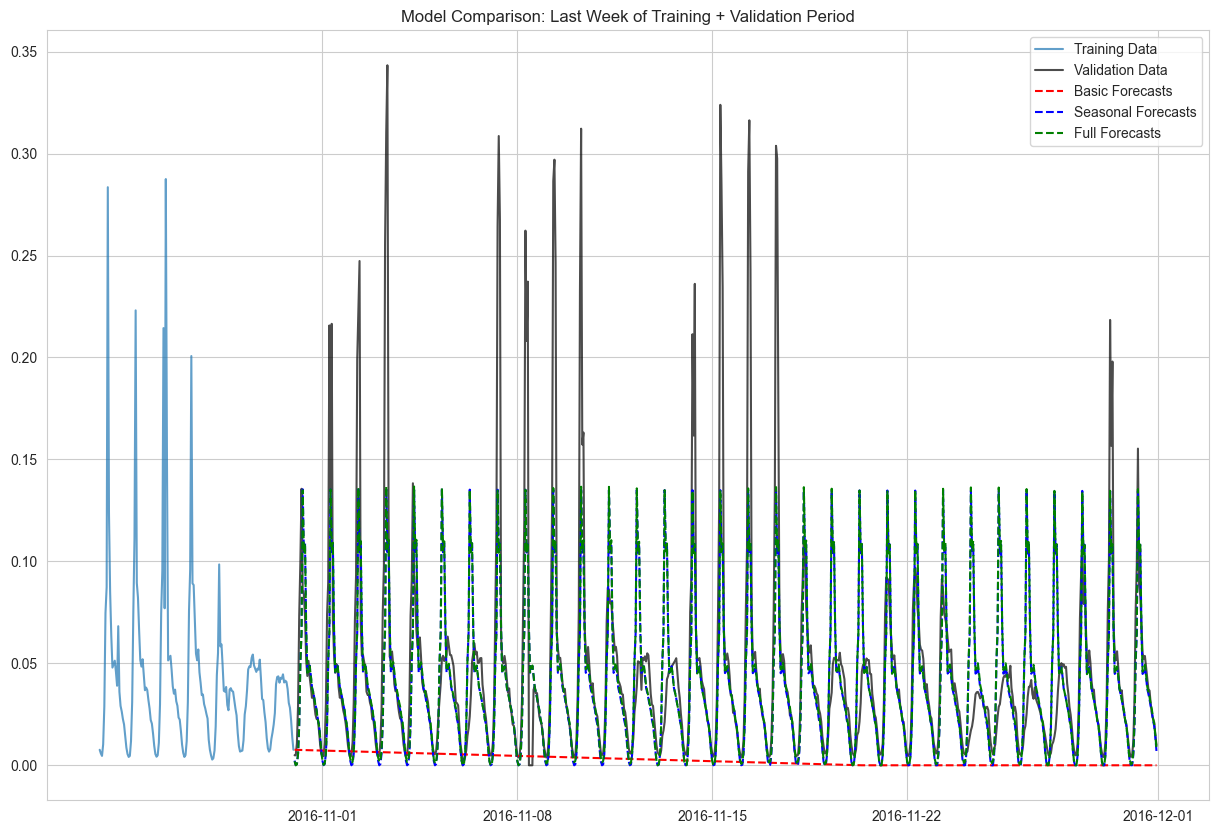


Model Comparison Metrics:
        Basic  Seasonal     Full
MAE    0.0439    0.0191   0.0188
RMSE   0.0686    0.0393   0.0392
MAPE  88.6095   49.1720  47.2086


In [35]:
# Cell 33 - Model Comparison and Visualization
def plot_model_comparison(train_data, val_data, models_dict):
    plt.figure(figsize=(15, 10))
    
    # Plot training data
    plt.plot(train_data.index[-168:], train_data['X'][-168:], 
             label='Training Data', alpha=0.7)
    
    # Plot validation data
    plt.plot(val_data.index, val_data['X'], 
             label='Validation Data', color='black', alpha=0.7)
    
    # Plot forecasts from each model
    colors = ['red', 'blue', 'green']
    for (name, forecasts), color in zip(models_dict.items(), colors):
        plt.plot(val_data.index, forecasts, 
                label=f'{name} Forecasts', 
                color=color, linestyle='--')
    
    plt.title('Model Comparison: Last Week of Training + Validation Period')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print comparison metrics
    print("\nModel Comparison Metrics:")
    metrics_df = pd.DataFrame({
        'Basic': basic_metrics,
        'Seasonal': seasonal_metrics,
        'Full': full_metrics
    }).round(4)
    print(metrics_df)

# Create dictionary of model forecasts
forecasts_dict = {
    'Basic': basic_forecasts,
    'Seasonal': seasonal_forecasts,
    'Full': full_forecasts
}

# Plot comparison
plot_model_comparison(train_data, val_data, forecasts_dict)

In [36]:
# Cell 34 - Save Best Model Forecasts
def save_ucm_forecasts(forecasts, conf_int, model_name='ucm'):
    """Save forecasts to CSV file"""
    # Create forecast dates
    forecast_dates = pd.date_range(
        start=val_data.index[-1] + pd.Timedelta(hours=1),
        periods=len(forecasts),
        freq='H'
    )
    
    # Create and save forecast DataFrame
    forecast_df = pd.DataFrame({
        'datetime': forecast_dates,
        f'{model_name}_forecast': forecasts,
        f'{model_name}_lower': conf_int.iloc[:, 0],
        f'{model_name}_upper': conf_int.iloc[:, 1]
    })
    
    filename = f'{model_name}_forecasts.csv'
    forecast_df.to_csv(filename, index=False)
    print(f"Forecasts saved to {filename}")

# Save forecasts from the best model (we'll determine which one after running the comparison)
save_ucm_forecasts(full_forecasts, full_conf, 'ucm_full')

Forecasts saved to ucm_full_forecasts.csv


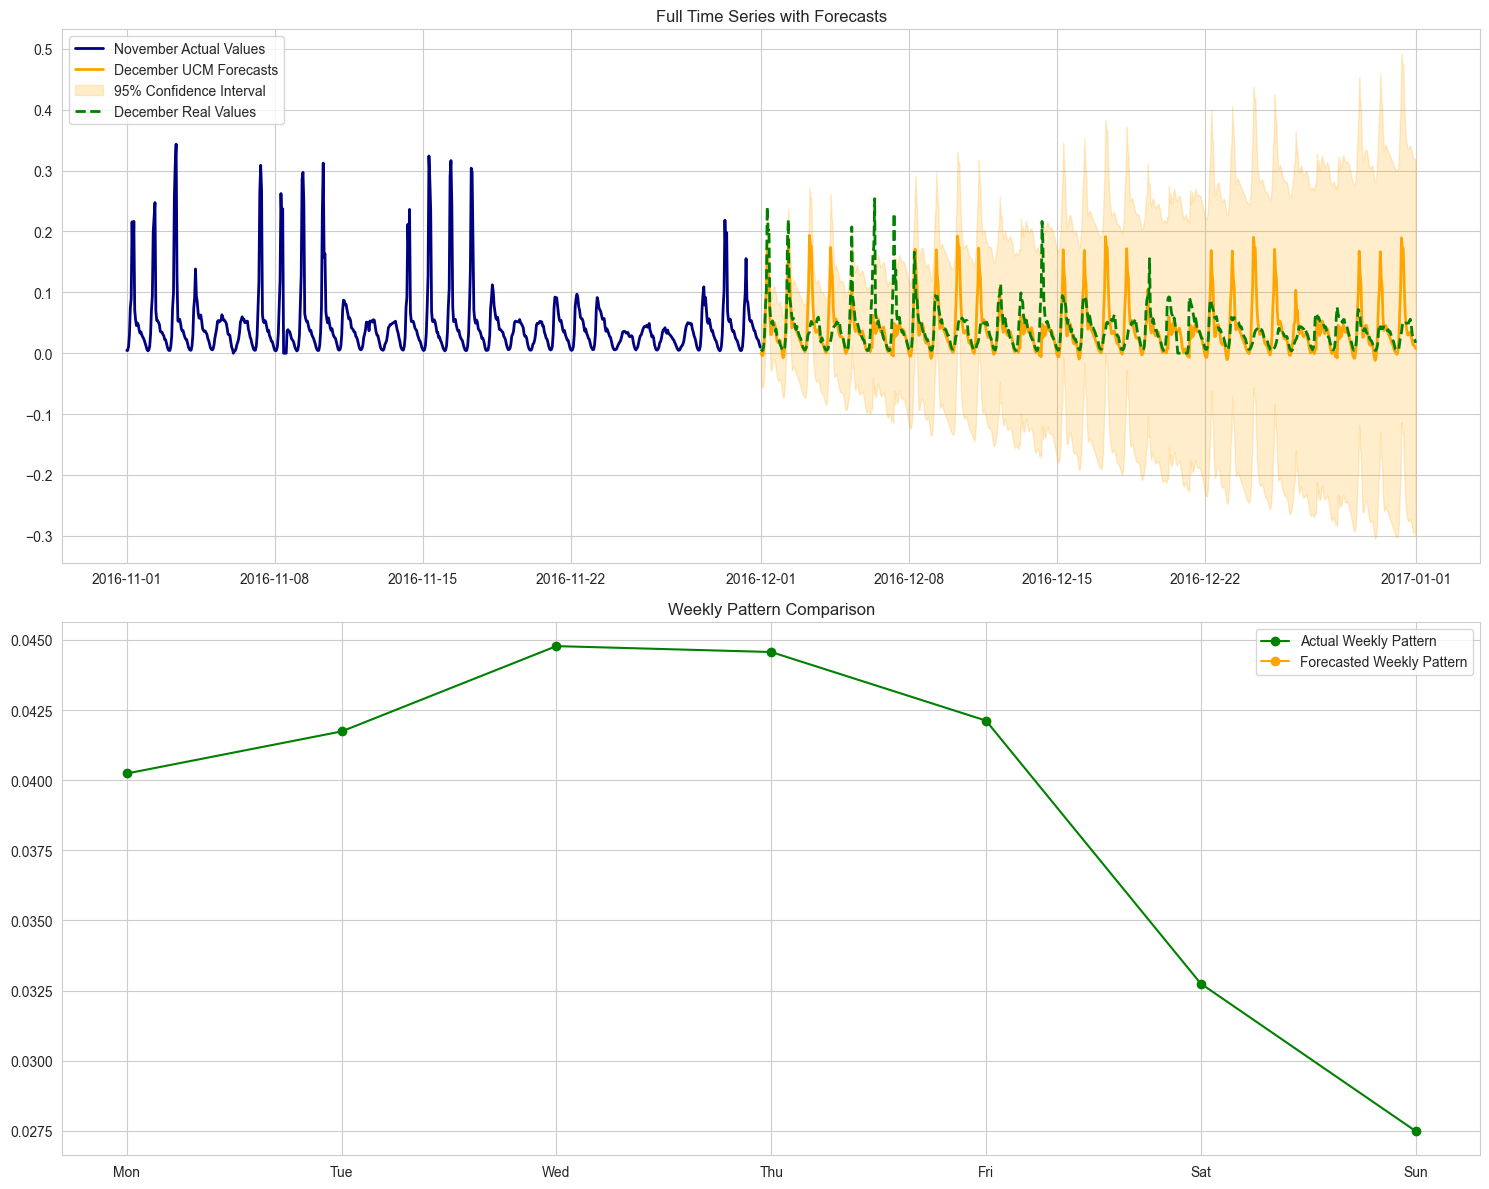


Forecast Error Metrics:
MAE: 0.0221
RMSE: 0.0393
MAPE: nan%


In [43]:
# Cell 35 (Updated) - Enhanced Visualization with Multiple Seasonalities
def plot_ucm_results(df, train_data, full_forecasts, full_conf, solution_path):
    """
    Plot comprehensive UCM results including both seasonalities
    """
    # Read solution data
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01',
                                 periods=len(solution),
                                 freq='H')
    
    # Get November data
    november_start = pd.to_datetime('2016-11-01')
    november_end = pd.to_datetime('2016-11-30 23:00:00')
    november_data = df[df.index.to_series().between(november_start, november_end)]
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))
    
    # Plot 1: Full time series
    ax1 = plt.subplot(211)
    ax1.plot(november_data.index, november_data['X'],
             label='November Actual Values',
             color='#000080',
             linewidth=2)
    
    forecast_dates = pd.date_range(start='2016-12-01',
                                 periods=len(full_forecasts),
                                 freq='H')
    
    ax1.plot(forecast_dates, full_forecasts,
             label='December UCM Forecasts',
             color='#FFA500',
             linewidth=2)
    
    ax1.fill_between(forecast_dates,
                     full_conf.iloc[:, 0],
                     full_conf.iloc[:, 1],
                     color='#FFA500',
                     alpha=0.2,
                     label='95% Confidence Interval')
    
    ax1.plot(solution.index, solution['X'],
             label='December Real Values',
             color='#008000',
             linewidth=2,
             linestyle='--')
    
    ax1.set_title('Full Time Series with Forecasts')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Weekly pattern
    ax2 = plt.subplot(212)
    last_week = solution.groupby(solution.index.dayofweek)['X'].mean()
    forecast_week = pd.Series(full_forecasts, index=forecast_dates).groupby(forecast_dates.dayofweek).mean()
    
    ax2.plot(last_week.index, last_week.values,
             label='Actual Weekly Pattern',
             color='#008000',
             marker='o')
    ax2.plot(forecast_week.index, forecast_week.values,
             label='Forecasted Weekly Pattern',
             color='#FFA500',
             marker='o')
    
    ax2.set_xticks(range(7))
    ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    ax2.set_title('Weekly Pattern Comparison')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print error metrics
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], full_forecasts)
    rmse = np.sqrt(mean_squared_error(solution['X'], full_forecasts))
    mape = np.mean(np.abs((solution['X'] - full_forecasts) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")

# Execute the visualization
solution_path = 'solution/t2_solution.csv'
plot_ucm_results(df, train_data, full_forecasts, full_conf, solution_path)


Forecast Error Metrics vs Real December Values:
MAE: 0.0148
RMSE: 0.0266
MAPE: nan%


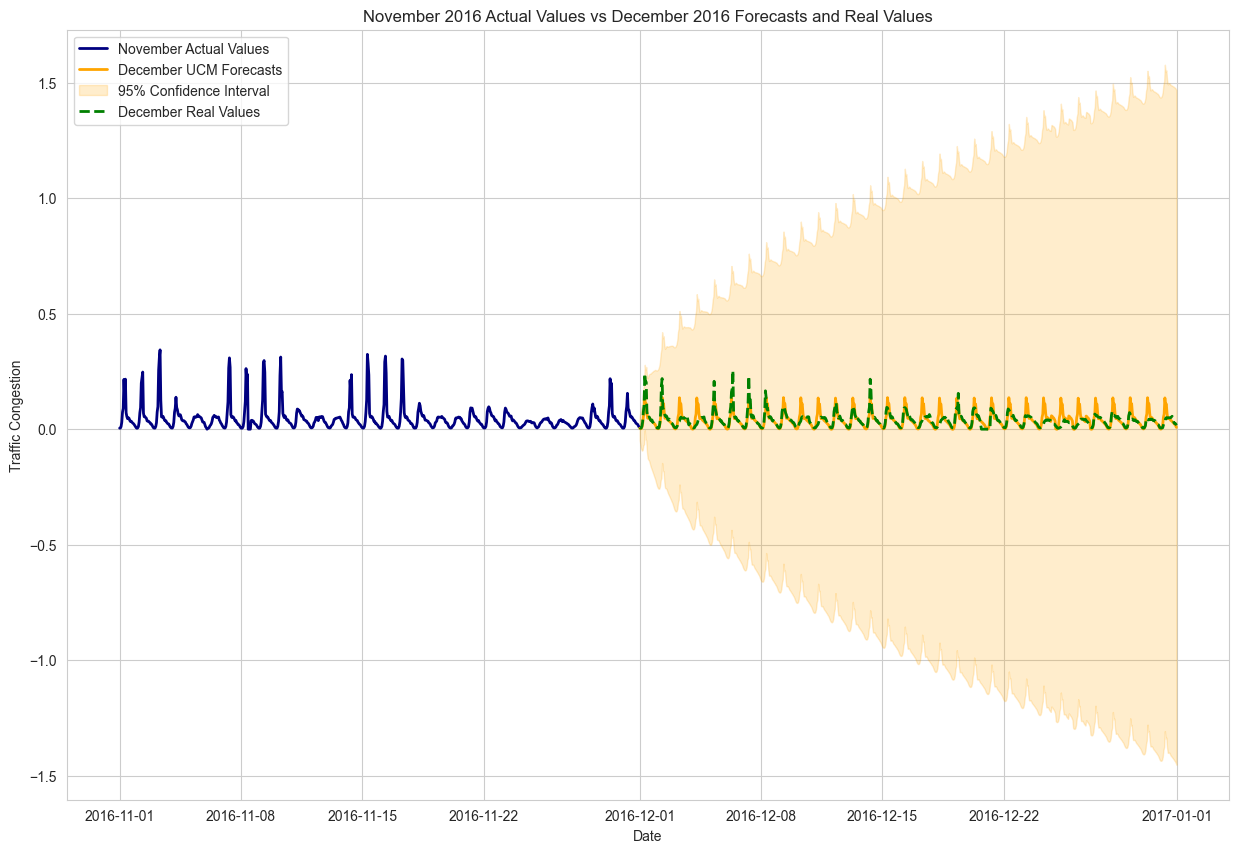

In [37]:
# Cell 35 (Updated Again) - Plot UCM Predictions vs Reality with Fixed CI
def plot_ucm_forecast_vs_reality(df, train_data, ucm_model, solution_path):
    """
    Plot November 2016 actual values, December 2016 UCM forecasts, and December 2016 real values
    
    Parameters:
    -----------
    df : pd.DataFrame
        Original complete DataFrame
    train_data : pd.DataFrame
        Training data used for model fitting
    ucm_model : UnobservedComponents
        Fitted UCM model
    solution_path : str
        Path to solution file
    """
    # Read solution data
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(start='2016-12-01',
                                 periods=len(solution),
                                 freq='H')
    
    # Get November data - using explicit datetime index
    november_start = pd.to_datetime('2016-11-01')
    november_end = pd.to_datetime('2016-11-30 23:00:00')
    november_data = df[df.index.to_series().between(november_start, november_end)]
    
    # Create future exogenous features for December
    future_dates = pd.date_range(start='2016-12-01',
                               periods=744,  # One month
                               freq='H')
    
    future_df = pd.DataFrame(index=future_dates)
    future_df['hour'] = future_df.index.hour
    future_df['day_of_week'] = future_df.index.dayofweek
    
    # Create cyclical features
    future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour']/24)
    future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour']/24)
    future_df['day_sin'] = np.sin(2 * np.pi * future_df['day_of_week']/7)
    future_df['day_cos'] = np.cos(2 * np.pi * future_df['day_of_week']/7)
    
    # Christmas evening indicator
    christmas_evenings = ((future_df.index.month == 12) & 
                         (future_df.index.day.isin([24, 25, 26])) &
                         (future_df.index.hour.isin(range(18, 24))))
    future_df['christmas_evening'] = christmas_evenings.astype(int)
    
    # Get exogenous features in correct order
    future_exog = future_df[['hour_sin', 'hour_cos', 
                            'day_sin', 'day_cos',
                            'christmas_evening']]
    
    # Generate forecasts using model's native prediction
    forecast_res = ucm_model.get_forecast(steps=744, exog=future_exog)
    forecasts = forecast_res.predicted_mean
    conf_int = forecast_res.conf_int(alpha=0.05)  # 95% confidence interval
    
    # Create plot
    plt.figure(figsize=(15, 10))
    
    # Plot November actual values (Dark Blue)
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values',
             color='#000080',  # Dark Blue
             linewidth=2)
    
    # Plot December forecasts (Orange)
    plt.plot(future_dates, forecasts,
             label='December UCM Forecasts',
             color='#FFA500',  # Orange
             linewidth=2)
    
    # Add confidence intervals (Light Orange shading)
    plt.fill_between(future_dates,
                    conf_int.iloc[:, 0],  # Lower bound
                    conf_int.iloc[:, 1],  # Upper bound
                    color='#FFA500',  # Orange
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    # Plot December real values (Green)
    plt.plot(solution.index, solution['X'],
             label='December Real Values',
             color='#008000',  # Green
             linewidth=2,
             linestyle='--')
    
    plt.title('November 2016 Actual Values vs December 2016 Forecasts and Real Values')
    plt.ylabel('Traffic Congestion')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print error metrics between forecasts and real values
    print("\nForecast Error Metrics vs Real December Values:")
    mae = mean_absolute_error(solution['X'], forecasts)
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts))
    mape = np.mean(np.abs((solution['X'] - forecasts) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    
    plt.show()

# Call the function with our full UCM model and the original DataFrame
solution_path = 'solution/t2_solution.csv'
plot_ucm_forecast_vs_reality(df, train_data, full_model, solution_path)

# New UCM?

In [49]:
# Cell 25 - UCM Model Setup and Utilities
from statsmodels.tsa.statespace.structural import UnobservedComponents
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def create_ucm_features(dates):
    """
    Create features for UCM models
    """
    features = pd.DataFrame(index=dates)
    
    # Christmas evening indicator (Dec 25-26)
    christmas_evenings = ((dates.day.isin([25, 26])) & 
                         (dates.hour.isin(range(20, 24))) |
                         (dates.day.isin([26, 27])) & 
                         (dates.hour.isin(range(0, 6))))
    features['christmas_evening'] = christmas_evenings.astype(int)
    
    return features

def fit_ucm_model(data, model_type='basic', exog=None):
    """
    Fit UCM model with specified configuration
    
    Parameters:
    - data: pandas Series with datetime index
    - model_type: 'basic' (daily), 'dual' (daily+weekly), or 'full' (with exog)
    - exog: exogenous variables DataFrame (optional)
    """
    print(f"\nFitting {model_type} UCM model...")
    
    try:
        if model_type == 'basic':
            # Daily seasonality only
            mod = UnobservedComponents(
                data,
                level='local linear trend',
                seasonal=24,  # 24-hour seasonality
                stochastic_level=True,
                stochastic_seasonal=True
            )
        elif model_type == 'dual':
            # Daily + Weekly seasonality
            mod = UnobservedComponents(
                data,
                level='local linear trend',
                seasonal=24,  # 24-hour seasonality
                freq_seasonal=[{'period': 168, 'harmonics': 3}],  # Weekly pattern
                stochastic_level=True,
                stochastic_seasonal=True
            )
        elif model_type == 'full':
            # Daily + Weekly + Exogenous
            mod = UnobservedComponents(
                data,
                level='local linear trend',
                seasonal=24,
                freq_seasonal=[{'period': 168, 'harmonics': 3}],
                stochastic_level=True,
                stochastic_seasonal=True,
                exog=exog
            )
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        # Fit the model
        res = mod.fit(disp=False)
        print(f"Model AIC: {res.aic:.2f}")
        print(f"Model BIC: {res.bic:.2f}")
        
        return res
        
    except Exception as e:
        print(f"Error fitting UCM model: {str(e)}")
        raise

def generate_ucm_forecasts(model, steps, exog=None):
    """
    Generate forecasts from fitted UCM model
    """
    try:
        # Generate forecasts
        forecast = model.forecast(steps=steps, exog=exog)
        forecast = np.maximum(forecast, 0)  # Ensure non-negative
        
        # Get prediction intervals
        pred = model.get_prediction(start=model.nobs, end=model.nobs + steps - 1,
                                  exog=exog)
        forecast_ci = pred.conf_int()
        forecast_ci.iloc[:, 0] = np.maximum(forecast_ci.iloc[:, 0], 0)
        
        return forecast, forecast_ci
        
    except Exception as e:
        print(f"Error generating forecasts: {str(e)}")
        raise

def plot_ucm_results(train_data, val_data, forecast, forecast_ci, 
                    model_name, forecast_dates):
    """
    Plot UCM model results
    """
    plt.figure(figsize=(15, 8))
    
    # Plot training data
    plt.plot(train_data.index, train_data, 
             label='Training Data', alpha=0.7)
    
    # Plot validation data
    plt.plot(val_data.index, val_data, 
             label='Validation Data', color='green', alpha=0.7)
    
    # Plot forecasts
    plt.plot(forecast_dates, forecast, 
             label=f'{model_name} Forecasts', color='red')
    
    # Add confidence intervals
    plt.fill_between(forecast_dates,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1],
                    color='red', alpha=0.1,
                    label='95% Confidence Interval')
    
    plt.title(f'UCM Model Forecasts ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_ucm_model(actual, predicted, model_name):
    """
    Calculate and print error metrics for UCM model
    """
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\nError Metrics for {model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape}

In [50]:
# Cell 26 - Fit UCM Models
def run_ucm_pipeline(train_set, val_set, forecast_horizon=744):
    """
    Run complete UCM modeling pipeline
    """
    print("=== Running UCM Modeling Pipeline ===")
    
    # Prepare data
    y = train_set['X'].astype(float)
    
    # Create features for the full model
    exog_train = create_ucm_features(train_set.index)
    exog_forecast = create_ucm_features(
        pd.date_range(start=train_set.index[-1] + pd.Timedelta(hours=1),
                     periods=forecast_horizon,
                     freq='H')
    )
    
    # Dictionary to store results
    results = {}
    
    # 1. Basic UCM (daily seasonality)
    print("\nFitting Basic UCM (Daily Seasonality)...")
    model_basic = fit_ucm_model(y, model_type='basic')
    forecast_basic, forecast_ci_basic = generate_ucm_forecasts(
        model_basic, forecast_horizon
    )
    results['basic'] = {
        'model': model_basic,
        'forecast': forecast_basic,
        'forecast_ci': forecast_ci_basic
    }
    
    # 2. Dual Seasonality UCM (daily + weekly)
    print("\nFitting Dual Seasonality UCM...")
    model_dual = fit_ucm_model(y, model_type='dual')
    forecast_dual, forecast_ci_dual = generate_ucm_forecasts(
        model_dual, forecast_horizon
    )
    results['dual'] = {
        'model': model_dual,
        'forecast': forecast_dual,
        'forecast_ci': forecast_ci_dual
    }
    
    # 3. Full UCM (with exogenous variables)
    print("\nFitting Full UCM...")
    model_full = fit_ucm_model(y, model_type='full', exog=exog_train)
    forecast_full, forecast_ci_full = generate_ucm_forecasts(
        model_full, forecast_horizon, exog=exog_forecast
    )
    results['full'] = {
        'model': model_full,
        'forecast': forecast_full,
        'forecast_ci': forecast_ci_full
    }
    
    return results

In [ ]:
# Cell 27 - Execute UCM Pipeline
# Execute the UCM pipeline
try:
    ucm_results = run_ucm_pipeline(train_set, val_set)
    
    # Create forecast dates
    forecast_dates = pd.date_range(
        start=train_set.index[-1] + pd.Timedelta(hours=1),
        periods=744,
        freq='H'
    )
    
    # Plot results for each model
    for model_type, results in ucm_results.items():
        plot_ucm_results(
            train_set['X'],
            val_set['X'],
            results['forecast'],
            results['forecast_ci'],
            f'UCM {model_type.capitalize()}',
            forecast_dates
        )
        
        # Evaluate on validation set
        evaluate_ucm_model(
            val_set['X'],
            results['forecast'][:len(val_set)],
            f'UCM {model_type.capitalize()}'
        )
    
    # Save forecasts to CSV
    for model_type, results in ucm_results.items():
        forecast_df = pd.DataFrame({
            'datetime': forecast_dates,
            f'UCM_{model_type}_forecast': results['forecast'],
            f'UCM_{model_type}_lower': results['forecast_ci'].iloc[:, 0],
            f'UCM_{model_type}_upper': results['forecast_ci'].iloc[:, 1]
        })
        forecast_df.to_csv(f'ucm_forecasts_{model_type}.csv', index=False)
        
    print("\nUCM modeling pipeline completed!")
    print("Forecasts have been saved to separate CSV files.")

except Exception as e:
    print(f"Error in UCM pipeline: {str(e)}")
    raise

=== Running UCM Modeling Pipeline ===

Fitting Basic UCM (Daily Seasonality)...

Fitting basic UCM model...


In [ ]:
# Cell 28 - Plot Comparative Results
def plot_model_comparisons(train_data, val_data, ucm_results, solution_path):
    """
    Create comparative plots for all UCM models against actual values
    """
    # Read solution data
    solution = pd.read_csv(solution_path)
    solution.index = pd.date_range(
        start='2016-12-01',
        periods=len(solution),
        freq='H'
    )
    
    # Get November data for context
    november_data = train_data['X'].loc['2016-11-01':'2016-11-30 23:00:00']
    
    # Create forecast dates
    forecast_dates = pd.date_range(
        start=train_data.index[-1] + pd.Timedelta(hours=1),
        periods=744,
        freq='H'
    )
    
    # Plot setup
    plt.figure(figsize=(15, 10))
    
    # Plot November data
    plt.plot(november_data.index, november_data,
             label='November Actual Values',
             color='#000080',  # Dark Blue
             linewidth=2)
    
    # Plot each model's forecasts with distinct colors
    colors = ['#FFA500', '#008000', '#800080']  # Orange, Green, Purple
    for (model_type, results), color in zip(ucm_results.items(), colors):
        plt.plot(forecast_dates, results['forecast'],
                label=f'UCM {model_type.capitalize()} Forecasts',
                color=color,
                linewidth=2,
                alpha=0.7)
    
    # Plot December actual values
    plt.plot(solution.index, solution['X'],
             label='December Actual Values',
             color='#FF0000',  # Red
             linewidth=2,
             linestyle='--')
    
    plt.title('UCM Models Comparison')
    plt.xlabel('Date')
    plt.ylabel('Traffic Congestion')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print comparative metrics
    print("\nComparative Error Metrics:")
    for model_type, results in ucm_results.items():
        print(f"\nUCM {model_type.capitalize()}:")
        evaluate_ucm_model(
            solution['X'],
            results['forecast'],
            f'UCM {model_type.capitalize()}'
        )

# Execute comparison plots
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists(solution_path):
    print("Plotting model comparisons...")
    plot_model_comparisons(train_set, val_set, ucm_results, solution_path)
else:
    print("Solution file not found. Please check the path.")